In [1]:
import joblib
joblib.cpu_count()

32

In [2]:
# !pip install --upgrade pip

import os
import gc
from joblib import Parallel, delayed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
from sklearn.svm import OneClassSVM
from dataclasses import asdict
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns


# Global utitlity functions are in separate notebook
%run ./Classification_utility-functions.ipynb
%run ./SEED-CONSTANTS.ipynb


EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT={}
for cv_fold_idx in range(len(THREE_FOLD_CV)):
    
    EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]=get_exp_deep_feature_extractors_dict_LOOCV(exp_num=EXP_NUM_2_2, # use Butter+EMA
                                                                              model_architectures=list(TRAINING_CONFIG_CV_DICT["Butter-EMA"][cv_fold_idx]['1000'].keys()), 
                                                                              window_size_lst=WINDOW_SIZE_LST_NN,
                                                                              variant_suffix=f"Butter33-EMA20-cv{cv_fold_idx}")
    
np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")


print("Setup Complete")

SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case
EER: 0.167, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.333, Threshold: 1.000 <-- Worse case
--------------------Utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Preprocessing utility functions imported--------------------
SEED: 567
FINAL_EXP_RESULTS_PATH: clip=False_experiments_results
--------------------SEED and CONSTANTS imported--------------------
SEED: 567
Python 3.9.10
--------------------Neu

2023-08-24 22:52:32.672551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 22:52:33.596531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43486 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e3:00.0, compute capability: 8.6


clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/2.2/SCNN_3_1_conv_1_dense_arg_dict_default/250/SCNN-standalone-2.2-SCNN_3_1_conv_1_dense_arg_dict_default-250-deep_feature_extractor-Butter33-EMA20-cv0
clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/2.2/SCNN_3_1_conv_1_dense_arg_dict_default/500/SCNN-standalone-2.2-SCNN_3_1_conv_1_dense_arg_dict_default-500-deep_feature_extractor-Butter33-EMA20-cv0
clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/2.2/SCNN_3_1_conv_1_dense_arg_dict_default/750/SCNN-standalone-2.2-SCNN_3_1_conv_1_dense_arg_dict_default-750-deep_feature_extractor-Butter33-EMA20-cv0
clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/2.2/SCNN_3_1_conv_1_dense_arg_dict_default/1000/SCNN-standalone-2.2-SCNN_3_1_conv_1_dense_arg_dict_default-1000-deep_feature_extractor-Butter33-EMA20-cv0
clip=False_experiments_results/SCNN_trained_models/SCNN-standalone/2.2/SCNN_3_2_conv_1_dense_arg_dict_default/125/SCNN-sta

In [3]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    ocsvm_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_OCSVM = ExperimentParameters(
    name="NAIVE-MINMAX_OCSVM",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    ocsvm_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    ocsvm_kernel="rbf",
    ocsvm_nu=None,
    ocsvm_gamma=None,
    feature_cols=[
        "x_a",
        "y_a",
        "z_a",
        "x_g",
        "y_g",
        "z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-MINMAX-OCSVM",
    scaler_global=False,
    ocsvm_nu=0.165,
    ocsvm_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="NAIVE-ROBUST-OCSVM",
    scaler="robust",
    scaler_global=True,
    ocsvm_nu=0.153,
    ocsvm_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_OCSVM_125 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)


VALID_ROBUST_OCSVM_250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1250 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1500 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_1750 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

VALID_ROBUST_OCSVM_2000 = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-ROBUST-OCSVM",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     ocsvm_nu=0.037,
#     ocsvm_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_OCSVM = dataclasses.replace(
    NAIVE_MINMAX_OCSVM,
    name="VALID-NORMALIZER-OCSVM",
    scaler="Normalizer",
    scaler_global=False,
    ocsvm_nu=0.074,
    ocsvm_gamma= 0.029,
)

In [4]:
P = VALID_ROBUST_OCSVM_2000
P.ocsvm_step_width = int(P.window_size * .5)

In [5]:
# P.user_ids+=[47]

In [6]:
P.num_sample_points_per_exp=18000
# P.user_ids+=[47]

In [7]:
P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx = P.exp_begin_cutoff_idx+3000//2, P.exp_end_cutoff_idx-3000//2
P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx

(2000, -2000)

In [8]:
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
raw_dfList_exp1, raw_dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 26951, gyro_count: 30434
2) accel_count: 24539, gyro_count: 27426
3) accel_count: 26902, gyro_count: 30139
4) accel_count: 23402, gyro_count: 24563
5) accel_count: 22779, gyro_count: 22838
6) accel_count: 23511, gyro_count: 23561
7) accel_count: 23806, gyro_count: 23877
8) accel_count: 20447, gyro_count: 20188
19) accel_count: 22704, gyro_count: 23461
21) accel_count: 22836, gyro_count: 22314
22) accel_count: 27744, gyro_count: 27293
26) accel_count: 21736, gyro_count: 22703
27) accel_count: 22797, gyro_count: 22091
28) accel_count: 22330, gyro_count: 23000
29) accel_count: 22498, gyro_count: 21989
35) accel_count: 22910, gyro_count: 22151
36) accel_count: 22748, gyro_count: 22690
37) accel_count: 30512, gyro_count: 30297
38) accel_count: 20655, gyro_count: 20807
39) accel_count: 22072, gyro_count: 21960
40) accel_count: 21593, gyro_count: 22760
41) accel_count: 22588, gyro_count: 22195
42) accel_count: 22647, gyro_count: 22755
43) accel_count: 21190,

In [9]:
df_exps_dict = load_data_frames([47], 500, -500, P.num_sample_points_per_exp)
raw_dfList_exp1_user_47, raw_dfList_exp2_user_47 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

raw_dfList_exp1+=raw_dfList_exp1_user_47
raw_dfList_exp2+=raw_dfList_exp2_user_47


Loading exp1 data:
47) accel_count: 22777, gyro_count: 22226
Loading exp2 data:
47) accel_count: 17718, gyro_count: 18353


In [10]:
len(raw_dfList_exp1)
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [11]:
def make_raw_X_exp(raw_df, windows):
    '''
    returns a list of window chuncks of raw_df based on the window indeces that are given.
    '''
    df_lst=[]
    for i in range(len(windows)):
        df_window=raw_df.iloc[windows[i], :].copy()
        df_lst.append(df_window)
    
    return df_lst

def delete_diagonal(array):
    '''
    returns a matrix whose diagonal is deleted. this is meant for the disimilarity matrix of the owner vs owner,
    since for owner vs owner the diagonal is 0 and does not have any meaning
    '''
    
    # index 1 of shape corresponds to columns of the matrix, and the result should have one less number of columns
    result_shape=(array.shape[0], array.shape[1]-1, array.shape[2])
    result = np.full(result_shape, np.nan, dtype=array.dtype)
    for i in range(array.shape[0]):
        
        # omit the diagonal element
        result[i] = np.concatenate((array[i, :i], array[i, i+1:]), axis=0)
        
    return result



def FMA(df, winsize):
    """
    FMA is defined because WACA uses it on their paper, we can also add it to our own experiments
    Compute the Forward Moving Average (FMA) by reversing the data,
    computing the SMA on the reversed data using pandas, and reversing the result back.

    Parameters:
    - data: A 1-dimensional array or list of data points.
    - window_size: The number of data points to include in the average, moving forward.

    Returns:
    - A 1-dimensional array of the forward moving averages.
    """
    # Reverse the input data
    reversed_df = df[::-1]
    # Create a pandas Series from the reversed data
    
    # Compute the SMA on the reversed data using pandas rolling mean
    sma = get_SMAed_df(reversed_df, winsize)

    # Reverse the result back
    return sma[::-1]

In [12]:
def make_FRR_dist_matrix_dict(dfList_exp, user_idx_set, window_size = 1000, step = 1000, numSamplePoints= 18000):
    '''
    dfLists are of the same size.
    '''
        
    users_exp_df_dict = {user_key: dfList_exp[user_key] for user_key in user_idx_set}
    print(f"len(exp1_df_user_set_dict): {len(exp_df_user_set_dict)}")
    fma_winsize=3
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    owner_owner_dis_matrix_dict={}
    for user_key in users_exp_df_dict:
        
        raw_df=FMA(users_exp_df_dict[user_key], fma_winsize)
        
        X_exp=make_raw_X_exp(raw_df, windows)
        
        encoding_array_exp = WACA_feature_extractor(X_exp)
        
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Fit on the data and transform it
        scaled_encoding_array_exp = scaler.fit_transform(encoding_array_exp)
        
        dis_matrix = (scaled_encoding_array_exp[None, :] - scaled_encoding_array_exp[:, None])
        
        dis_matrix = delete_diagonal(dis_matrix)

        owner_owner_dis_matrix_dict[user_key]=dis_matrix
        
            
    return owner_owner_dis_matrix_dict

def make_dist_matrix_dict(dfList_exp, user_idx_set, feature_extractor_func, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=3):
    
    # convert dfList to a user: df dictionary such that the keys are indeces coming from user_idx_set
    users_exp_df_dict = {user_key: dfList_exp[user_key] for user_key in user_idx_set}
    print(f"len(users_exp_df_dict): {len(users_exp_df_dict)}")
    
    # windows list for slicing the user raw_df into lst of df_windows
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    # contains a list of the dis matrix of owner vs itself, the dis is given in a list of one element
    owner_owner_dis_matrix_dict={}
    
    # contains a list of dis matrices of an each owner against other users
    owner_adversary_dis_matrix_dict={}
    
    # calculate and save the owner waca encoding arrays to save computational time
    owner_encoding_array_dict={}
    unknown_encoding_array_dict={}
    
    user_fitted_scaler_dict={}
    for user_key in users_exp_df_dict:
        
        # apply FMA on the entirety of user data before slicing
        raw_df=FMA(users_exp_df_dict[user_key], fma_winsize)
        
        
        raw_df=raw_df.drop("time_stamp", axis=1)
        
        
        # sclicing user data into predefined windows
        X_exp=make_raw_X_exp(raw_df, windows)
        
        
        # extracting waca features for each window
        # encoding_array_exp = WACA_feature_extractor(X_exp)
        encoding_array_exp = feature_extractor_func(X_exp)
        
        # fit scaler on user x and transform user x data
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1), clip=False)

        # Fit on the data
        user_fitted_scaler_dict[user_key] = scaler.fit(encoding_array_exp)
        
        # and transform it
        scaled_encoding_array_exp = user_fitted_scaler_dict[user_key].transform(encoding_array_exp)
        
        
        owner_encoding_array_dict[user_key] = scaled_encoding_array_exp
        
        
        unknown_encoding_array_dict[user_key] = encoding_array_exp
    
    
    
    
    for owner_key in users_exp_df_dict:
        
        # initializing
        owner_owner_dis_matrix_dict[owner_key]=[]
        owner_adversary_dis_matrix_dict[owner_key]=[]
        
        for unknown_key in users_exp_df_dict:
            
            scaled_unknown_encoding_array = user_fitted_scaler_dict[owner_key].transform(unknown_encoding_array_dict[unknown_key])
            
#             print(f"num zeroes for {owner_key}, unknown_key: {unknown_key}, {np.sum(scaled_unknown_encoding_array==0)/(84*len(scaled_unknown_encoding_array))}")
#             print(f"num ones for {owner_key}, unknown_key: {unknown_key}, {np.sum(scaled_unknown_encoding_array==1)/(84*len(scaled_unknown_encoding_array))}")
            
#             if  owner_key==13 and unknown_key==8:
#                 print(scaled_unknown_encoding_array)
#                 print(owner_encoding_array_dict[owner_key])
            
#                 return scaled_unknown_encoding_array, owner_encoding_array_dict[owner_key]
            
            # calculate the disimilarity matrix between the owner and the unkown user data
            dis_matrix = (owner_encoding_array_dict[owner_key][None, :] - scaled_unknown_encoding_array[:, None])
            
            # if it is owner vs owner
            if owner_key == unknown_key:
                
                # delete as the diagonal is all zeros and does not mean anything
                dis_matrix = delete_diagonal(dis_matrix)

                owner_owner_dis_matrix_dict[owner_key].append(dis_matrix)
            
            else:
                
                owner_adversary_dis_matrix_dict[owner_key].append(dis_matrix)
        
                
    
    return {"owner_owner_dis_matrix_dict": owner_owner_dis_matrix_dict, "owner_adversary_dis_matrix_dict": owner_adversary_dis_matrix_dict}



In [13]:
def make_dist_matrix_dict_exp2_vs_exp1(dfList_exp2, dfList_exp1, user_idx_set, feature_extractor_func, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=3):
    
    # convert dfList to a user: df dictionary such that the keys are indeces coming from user_idx_set
    owner_exp_df_dict = {user_key: dfList_exp2[user_key] for user_key in user_idx_set}
    print(f"len(owner_exp_df_dict): {len(owner_exp_df_dict)}")
    
    unknown_exp_df_dict = {user_key: dfList_exp1[user_key] for user_key in user_idx_set}
    print(f"len(unknown_exp_df_dict): {len(unknown_exp_df_dict)}")
    
    # windows list for slicing the user raw_df into lst of df_windows
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    # contains a list of the dis matrix of owner vs itself, the dis is given in a list of one element
    owner_owner_dis_matrix_dict={}
    
    # contains a list of dis matrices of an each owner against other users
    owner_adversary_dis_matrix_dict={}
    
    # calculate and save the owner waca encoding arrays to save computational time
    owner_encoding_array_dict={}
    
    user_fitted_scaler_dict={}
    for user_key in owner_exp_df_dict:
        
        # apply FMA on the entirety of user data before slicing
        raw_df=FMA(owner_exp_df_dict[user_key], fma_winsize)
        
        
        raw_df=raw_df.drop("time_stamp", axis=1)
        
        
        # sclicing user data into predefined windows
        X_exp=make_raw_X_exp(raw_df, windows)
        
        
        # extracting waca features for each window
        # encoding_array_exp = WACA_feature_extractor(X_exp)
        encoding_array_exp = feature_extractor_func(X_exp)
        
        # fit scaler on user x and transform user x data
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1), clip=False)

        # Fit on the data
        user_fitted_scaler_dict[user_key] = scaler.fit(encoding_array_exp)
        
        # and transform it
        scaled_encoding_array_exp = user_fitted_scaler_dict[user_key].transform(encoding_array_exp)
        
        owner_encoding_array_dict[user_key] = scaled_encoding_array_exp
        
            
    unknown_encoding_array_dict={}
    for user_key in unknown_exp_df_dict:
        
        # apply FMA on the entirety of user data before slicing
        raw_df=FMA(unknown_exp_df_dict[user_key], fma_winsize)
        
        
        raw_df=raw_df.drop("time_stamp", axis=1)
        
        
        # sclicing user data into predefined windows
        X_exp=make_raw_X_exp(raw_df, windows)
        
        
        # extracting waca features for each window
        # encoding_array_exp = WACA_feature_extractor(X_exp)
        encoding_array_exp = feature_extractor_func(X_exp)
        
        unknown_encoding_array_dict[user_key] = encoding_array_exp
    
    
    
    for owner_key in owner_exp_df_dict:
        
        # initializing
        owner_owner_dis_matrix_dict[owner_key]=[]
        owner_adversary_dis_matrix_dict[owner_key]=[]
        
        for unknown_key in unknown_exp_df_dict:
            
            scaled_unknown_encoding_array = user_fitted_scaler_dict[owner_key].transform(unknown_encoding_array_dict[unknown_key])
            
#             print(f"num zeroes for {owner_key}, unknown_key: {unknown_key}, {np.sum(scaled_unknown_encoding_array==0)/(84*len(scaled_unknown_encoding_array))}")
#             print(f"num ones for {owner_key}, unknown_key: {unknown_key}, {np.sum(scaled_unknown_encoding_array==1)/(84*len(scaled_unknown_encoding_array))}")
            
#             if  owner_key==13 and unknown_key==8:
#                 print(scaled_unknown_encoding_array)
#                 print(owner_encoding_array_dict[owner_key])
            
#                 return scaled_unknown_encoding_array, owner_encoding_array_dict[owner_key]
            
            # calculate the disimilarity matrix between the owner and the unkown user data
            dis_matrix = (owner_encoding_array_dict[owner_key][None, :] - scaled_unknown_encoding_array[:, None])
            
            # if it is owner vs owner
            if owner_key == unknown_key:
                
                # delete as the diagonal is all zeros and does not mean anything
                dis_matrix = delete_diagonal(dis_matrix)

                owner_owner_dis_matrix_dict[owner_key].append(dis_matrix)
            
            else:
                
                owner_adversary_dis_matrix_dict[owner_key].append(dis_matrix)
        
                
    
    return {"owner_owner_dis_matrix_dict": owner_owner_dis_matrix_dict, "owner_adversary_dis_matrix_dict": owner_adversary_dis_matrix_dict}



In [14]:
# user_8_exp_1=raw_dfList_exp1[8].drop(["time_stamp"], axis=1)
# user_13_exp_1=raw_dfList_exp1[13].drop(["time_stamp"], axis=1)

In [15]:
# result=make_dist_matrix_dict(raw_dfList_exp1, randomized_data_idx, feature_extractor_func=WACA_feature_extractor, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=20)

In [16]:
# for v in result[0]:
#     print(v)
#     print('\n')

In [17]:
# result=make_dist_matrix_dict(raw_dfList_exp1, randomized_data_idx, feature_extractor_func=WACA_feature_extractor, window_size = 1000, step = 1000, numSamplePoints= 18000, fma_winsize=20)

In [18]:
# np.linalg.norm(np.concatenate(result["owner_adversary_dis_matrix_dict"][7], axis=1),  ord=2, axis=2).shape

In [19]:
# result.keys()
# shape = (10,)  # Modify the shape according to your requirements

# # Create an array of labels filled with -1
# np.concatenate([np.full(shape, -1), np.full(shape, -1)])

In [20]:
def calculate_user_EER(owner_owner_dis_matrix_dict, owner_adversary_dis_matrix_dict, minkowski_p):


    owner_eer_lst_dict={}
    for owner_key in owner_owner_dis_matrix_dict:
        
        owner_eer_lst_dict[owner_key]=[]
        
        # get owner vs owner dis matrix
        owner_owner_dm=np.concatenate(owner_owner_dis_matrix_dict[owner_key], axis=1)
        
        # get owner vs adversaries concatenated array of matrices
        owner_adversary_dm=np.concatenate(owner_adversary_dis_matrix_dict[owner_key], axis=1)
        
        # calculate chosen order of minkowski distance for owner vs owner and owner vs adversaries arrays
        # the distances are calculated in axis=2 as axis=0 and axis=1 correspnd to the entries while axis=2
        # corresponds to the subtracted result
        owner_owner_dm = np.linalg.norm(owner_owner_dm, ord=minkowski_p, axis=2)
        owner_adversary_dm = np.linalg.norm(owner_adversary_dm, ord=minkowski_p, axis=2)
        
        # make lables. +1 for owner vs owner, and -1 for owner vs adversaries
        pos_labels=np.full(owner_owner_dm.shape[1], 1)
        neg_labels=np.full(owner_adversary_dm.shape[1], -1)
        
        y_true=np.concatenate([pos_labels, neg_labels])
        
        for owner_window_idx in range(owner_owner_dm.shape[0]):
            
            # distance scores must be multiplied by -1 as higher distance should have lower score than lower distance
            y_score=-1*np.concatenate([owner_owner_dm[owner_window_idx], owner_adversary_dm[owner_window_idx]])
            
            # calculate equal error rate
            owner_eer_lst_dict[owner_key].append(equal_error_rate(y_true=y_true, y_score=y_score))
            
    return owner_eer_lst_dict

In [21]:
def make_raw_X_exp_NN(df, windows, exp_num, EMA_per_win_span=None, SMA_per_win_winsize=None, Butter_per_win_argdict=None, verbose_c=0):
    '''
    returns a list of window chunks of df based on the window indices that are given.
    '''
    # print(type(df))
    array_list = []
    # print(df.shape)
    
    for window in windows:
        # print(window)
        df_window = df[window, :].copy()
        
        # decided to only do naive for now
#         if exp_num==1:

#             if Butter_per_win_argdict!=None:


#                 filter_order = Butter_per_win_argdict["filter_order"]
#                 cut_off_freq = Butter_per_win_argdict["cut_off_freq"]
#                 sampling_freq = Butter_per_win_argdict["sampling_freq"]
#                 filtfilt = Butter_per_win_argdict["filtfilt"]

#                 if verbose_c==1: df_window["x_a"][0:500].plot()

#                 df_window = get_ffted_df(df_window, filter_order=filter_order, cut_off_freq=cut_off_freq, sampling_freq=sampling_freq, filtfilt=filtfilt)

#                 if verbose_c: 
#                     df_window["x_a"][0:500].plot()
#                     print(f"Butter_per_win_argdict: {Butter_per_win_argdict}")

#             # exponential moving average
#             if EMA_per_win_span!=None:

#                 df_window = get_EMAed_df(df_window, span=EMA_per_win_span)

#                 if verbose_c==1: 
#                     print("EMA_per_win_span")
#                     verbose_c-=1
                    
#             # simple moving average
#             elif SMA_per_win_winsize!=None:

#                 df_window = get_SMAed_df(df_window, winsize=SMA_per_win_winsize)
#                 if verbose_c==1: 
#                     print("SMA_per_win_span")
#                     verbose_c-=1
                
        array_list.append(df_window)
    
    return array_list


def make_dist_matrix_dict_NN(dfList_exp, user_idx_set, feature_extractor_func, window_size = 1000, step = 1000, numSamplePoints= 18000):
    
    # convert dfList to a user: df dictionary such that the keys are indeces coming from user_idx_set
    users_exp_df_dict = {user_key: dfList_exp[user_key] for user_key in user_idx_set}
    print(f"len(users_exp_df_dict): {len(users_exp_df_dict)}")
    
    # windows list for slicing the user raw_df into lst of df_windows
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    # contains a list of the dis matrix of owner vs itself, the dis is given in a list of one element
    owner_owner_dis_matrix_dict={}
    
    # contains a list of dis matrices of an each owner against other users
    owner_adversary_dis_matrix_dict={}
    
    # calculate and save the owner waca encoding arrays to save computational time
    owner_encoding_array_dict={}
    
    # keep raw version of data when user is unknown
    unknown_raw_df_dict={}
    
    # for every owner a pair of robust and minmax scaler applied sequentially
    user_fitted_raw_scaler_dict={}
    
    # this is for feature scaler
    user_fitted_scaler_dict={}
    for user_key in users_exp_df_dict:
        
        raw_df=users_exp_df_dict[user_key].copy().drop("time_stamp", axis=1)
        
        
        unknown_raw_df_dict[user_key] = raw_df.copy()
        
        # print(raw_df.shape)
        raw_scaler_1 = RobustScaler()
        raw_scaler_2 = MinMaxScaler(feature_range=(-1.0, 1.0), clip=False)
        
        raw_scaler_1 = raw_scaler_1.fit(raw_df)
        raw_df=raw_scaler_1.transform(raw_df)
        
        raw_scaler_2 = raw_scaler_2.fit(raw_df)
        raw_df=raw_scaler_2.transform(raw_df)
            
        user_fitted_raw_scaler_dict[user_key] = (raw_scaler_1, raw_scaler_2)
            
        # sclicing user data into predefined windows
        X_exp=make_raw_X_exp_NN(raw_df, windows, exp_num=None)
        
        
        # extracting waca features for each window
        # encoding_array_exp = WACA_feature_extractor(X_exp)
        encoding_array_exp = feature_extractor_func(X_exp)
        
        # fit scaler on user x and transform user x data
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1), clip=False)

        # Fit on the data
        user_fitted_scaler_dict[user_key] = scaler.fit(encoding_array_exp)
        
        # and transform it
        scaled_encoding_array_exp = user_fitted_scaler_dict[user_key].transform(encoding_array_exp)
        
        
        owner_encoding_array_dict[user_key] = scaled_encoding_array_exp
        
    
    
    
    
    for owner_key in users_exp_df_dict:
        
        # initializing
        owner_owner_dis_matrix_dict[owner_key]=[]
        owner_adversary_dis_matrix_dict[owner_key]=[]
        
        
        
        for unknown_key in unknown_raw_df_dict:
            
            unknown_raw_df = unknown_raw_df_dict[unknown_key].copy()

            # print(raw_df.shape)
            raw_scaler_1, raw_scaler_2 = user_fitted_raw_scaler_dict[owner_key] # shouldnt this be owner key????? unknown_key

            unknown_raw_df=raw_scaler_1.transform(unknown_raw_df)

            unknown_raw_df=raw_scaler_2.transform(unknown_raw_df)
            
            unknown_raw_array = make_raw_X_exp_NN(unknown_raw_df, windows, exp_num=None)
            
            unknown_encoding_array_exp = feature_extractor_func(unknown_raw_array)
            
            # print(unknown_encoding_array_exp.shape)
            scaled_unknown_encoding_array = user_fitted_scaler_dict[owner_key].transform(unknown_encoding_array_exp)
            
            # calculate the disimilarity matrix between the owner and the unkown user data
            dis_matrix = (owner_encoding_array_dict[owner_key][None, :] - scaled_unknown_encoding_array[:, None])
            
            # if it is owner vs owner
            if owner_key == unknown_key:
                
                # delete as the diagonal is all zeros and does not mean anything
                dis_matrix = delete_diagonal(dis_matrix)

                owner_owner_dis_matrix_dict[owner_key].append(dis_matrix)
            
            else:
                
                owner_adversary_dis_matrix_dict[owner_key].append(dis_matrix)
        
                
    
    return {"owner_owner_dis_matrix_dict": owner_owner_dis_matrix_dict, "owner_adversary_dis_matrix_dict": owner_adversary_dis_matrix_dict}




def make_dist_matrix_dict_NN_exp2_vs_exp1(dfList_exp2, dfList_exp1, user_idx_set, feature_extractor_func, window_size = 1000, step = 1000, numSamplePoints= 18000):
    
    # convert dfList to a user: df dictionary such that the keys are indeces coming from user_idx_set
    owner_exp_df_dict = {user_key: dfList_exp2[user_key] for user_key in user_idx_set}
    print(f"len(owner_exp_df_dict): {len(owner_exp_df_dict)}")
    
    unknown_exp_df_dict = {user_key: dfList_exp1[user_key] for user_key in user_idx_set}
    print(f"len(unknown_exp_df_dict): {len(unknown_exp_df_dict)}")
    
    # windows list for slicing the user raw_df into lst of df_windows
    windows = getIndices(sampleSize=window_size, step=step, numSamplePoints= numSamplePoints)

    # contains a list of the dis matrix of owner vs itself, the dis is given in a list of one element
    owner_owner_dis_matrix_dict={}
    
    # contains a list of dis matrices of an each owner against other users
    owner_adversary_dis_matrix_dict={}
    
    # calculate and save the owner waca encoding arrays to save computational time
    owner_encoding_array_dict={}
    
    # for every owner a pair of robust and minmax scaler applied sequentially
    user_fitted_raw_scaler_dict={}
    
    # this is for feature scaler
    user_fitted_scaler_dict={}
    for user_key in owner_exp_df_dict:
        
        # apply FMA on the entirety of user data before slicing
        raw_df=owner_exp_df_dict[user_key].copy().drop("time_stamp", axis=1)
                
        # print(raw_df.shape)
        raw_scaler_1 = RobustScaler()
        raw_scaler_2 = MinMaxScaler(feature_range=(-1.0, 1.0), clip=False)
        
        raw_scaler_1 = raw_scaler_1.fit(raw_df)
        raw_df=raw_scaler_1.transform(raw_df)
        
        raw_scaler_2 = raw_scaler_2.fit(raw_df)
        raw_df=raw_scaler_2.transform(raw_df)
            
        user_fitted_raw_scaler_dict[user_key] = (raw_scaler_1, raw_scaler_2)
            
        # sclicing user data into predefined windows
        X_exp=make_raw_X_exp_NN(raw_df, windows, exp_num=None)
        
        
        # extracting waca features for each window
        # encoding_array_exp = WACA_feature_extractor(X_exp)
        encoding_array_exp = feature_extractor_func(X_exp)
        
        # fit scaler on user x and transform user x data
        # Initialize the scaler with the desired range
        scaler = MinMaxScaler(feature_range=(0, 1), clip=False)

        # Fit on the data
        user_fitted_scaler_dict[user_key] = scaler.fit(encoding_array_exp)
        
        # and transform it
        scaled_encoding_array_exp = user_fitted_scaler_dict[user_key].transform(encoding_array_exp)
        
        
        owner_encoding_array_dict[user_key] = scaled_encoding_array_exp
        
    
#     unknown_raw_df_dict={}
#     for user_key in unknown_exp_df_dict:
        
#         # apply FMA on the entirety of user data before slicing
#         raw_df=FMA(unknown_exp_df_dict[user_key], fma_winsize)
        
        
#         raw_df=raw_df.drop("time_stamp", axis=1).to_numpy()
        
#         # sclicing user data into predefined windows
#         # X_exp=make_raw_X_exp(raw_df, windows)
#         print(raw_df.shape)
#         X_exp=make_raw_X_exp_NN(raw_df, windows=windows, exp_num=2, EMA_per_win_span=20, SMA_per_win_winsize=None, Butter_per_win_argdict=None, verbose_c=1)
#         print(raw_df.shape)
#         unknown_raw_df_dict[user_key] = X_exp
    
    
    
    for owner_key in owner_exp_df_dict:
        
        # initializing
        owner_owner_dis_matrix_dict[owner_key]=[]
        owner_adversary_dis_matrix_dict[owner_key]=[]
        
        
        
        for unknown_key in unknown_exp_df_dict:
            
            unknown_raw_df = unknown_exp_df_dict[unknown_key].copy().drop("time_stamp", axis=1)

            # print(raw_df.shape)
            raw_scaler_1, raw_scaler_2 = user_fitted_raw_scaler_dict[owner_key] # owner_key or unknown_key

            unknown_raw_df=raw_scaler_1.transform(unknown_raw_df)

            unknown_raw_df=raw_scaler_2.transform(unknown_raw_df)
            
            unknown_raw_array = make_raw_X_exp_NN(unknown_raw_df, windows, exp_num=None) #unknown_raw_df #
            
            unknown_encoding_array_exp = feature_extractor_func(unknown_raw_array)
            
            # print(unknown_encoding_array_exp.shape)
            scaled_unknown_encoding_array = user_fitted_scaler_dict[owner_key].transform(unknown_encoding_array_exp)
            
            
            # calculate the disimilarity matrix between the owner and the unkown user data
            dis_matrix = (owner_encoding_array_dict[owner_key][None, :] - scaled_unknown_encoding_array[:, None])
            
            # if it is owner vs owner
            if owner_key == unknown_key:
                
                # delete as the diagonal is all zeros and does not mean anything
                dis_matrix = delete_diagonal(dis_matrix)

                owner_owner_dis_matrix_dict[owner_key].append(dis_matrix)
            
            else:
                
                owner_adversary_dis_matrix_dict[owner_key].append(dis_matrix)
        
                
    
    return {"owner_owner_dis_matrix_dict": owner_owner_dis_matrix_dict, "owner_adversary_dis_matrix_dict": owner_adversary_dis_matrix_dict}



In [22]:
style = {
    "figure.figsize": (8, 6),
    "font.family": "serif",  # Ensure that we're using a serif font for LaTeX compatibility
    "text.usetex": True,  # Use LaTeX to format labels and titles    
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "lines.marker": 'o',
    "lines.markerfacecolor": 'none',
    "lines.markeredgecolor": 'auto',
    "lines.markeredgewidth": 1.5,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.53,
    "grid.linewidth": 0.8,
    "grid.color": "#D3D3D3",  # A light gray, you can adjust to preference
    "grid.linestyle": "--",
    "axes.facecolor": "white",  # background color of the axes (plotting area)
    "figure.facecolor": "white",  # background color of the figure
    "axes.edgecolor": "#333333",  # color of the borders
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
}
markers = ['o', 's', '^', 'v', '<', '>', 'D', 'd', 'p', 'h']

factor=2
style = {
    "figure.figsize": (8, 6),
    "font.family": "serif",  # Ensure that we're using a serif font for LaTeX compatibility
    "text.usetex": True,  # Use LaTeX to format labels and titles    
    "font.size": 12*factor,
    "axes.labelsize": 12*factor,
    "axes.titlesize": 14*factor,
    "xtick.labelsize": 10*factor,
    "ytick.labelsize": 10*factor,
    "lines.linewidth": 2*factor*(3/4),
    "lines.markersize": 8*factor,
    "lines.marker": None,
    "lines.markerfacecolor": 'none',
    "lines.markeredgecolor": 'auto',
    "lines.markeredgewidth": 1.5*factor*(3/4),
    "legend.fontsize": 10*factor,
    "legend.title_fontsize": 10*factor,
    "axes.grid": True,
    "grid.alpha": 0.53,
    "grid.linewidth": 0.8*factor*(3/4),
    "grid.color": "#D3D3D3",  # A light gray, you can adjust to preference
    "grid.linestyle": "--",
    "axes.facecolor": "white",  # background color of the axes (plotting area)
    "figure.facecolor": "white",  # background color of the figure
    "axes.edgecolor": "#333333",  # color of the borders
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
    
    # "font.weight": "bold",       # Bold all text
    # "axes.labelweight": "bold",  # Bold axis labels (redundant if the above line is used, but listed for clarity)
    # "axes.titleweight": "bold",  # Bold title
    # "legend.fontweight": "bold", # Bold legend text
}

plt.rcParams.update(style)
# plt.rc('text', usetex=True)  # Use LaTeX to format labels and titles




# 1) Classifier free EER distribution exp1 and exp2

## 1.1) exp2

In [24]:
fma_winsize=2
minkowski_p_lst=[1, 2, 5]

raw_data_dict_exp2={'x': WINDOW_SIZE_LST}
for minkowski_p in minkowski_p_lst:

    raw_data_dict_exp2[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST:
        
        cv_fold_result=[]
        for _, test_cv_fold in THREE_FOLD_CV:
            dis_matrix_dict=make_dist_matrix_dict(dfList_exp=raw_dfList_exp2, 
                                                  user_idx_set=test_cv_fold, 
                                                  feature_extractor_func=WACA_feature_extractor, 
                                                  window_size=window_size, 
                                                  step=window_size, 
                                                  numSamplePoints= P.num_sample_points_per_exp, 
                                                  fma_winsize=fma_winsize)
            

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict_exp2[minkowski_p].append(cv_fold_result)
            
    


data_dict_exp2={"label": "WACA"}
data_dict_exp2['x']=raw_data_dict_exp2['x']
for minkowski_p in minkowski_p_lst:
    data_dict_exp2[minkowski_p]=np.array(raw_data_dict_exp2[minkowski_p]).mean(axis=1)
    
WACA_data_dict_exp2=data_dict_exp2

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

In [25]:
data_dict_exp2

{'label': 'WACA',
 'x': [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],
 1: array([0.27451142, 0.18403031, 0.10466466, 0.0643053 , 0.04815891,
        0.03442933, 0.02867915, 0.02733333, 0.02065043]),
 2: array([0.24184726, 0.13822718, 0.06714767, 0.03687293, 0.02663298,
        0.01958181, 0.01685723, 0.01485185, 0.00976795]),
 5: array([0.20945429, 0.10012367, 0.03922517, 0.01724118, 0.01219606,
        0.00691537, 0.00341844, 0.00190741, 0.00055155])}

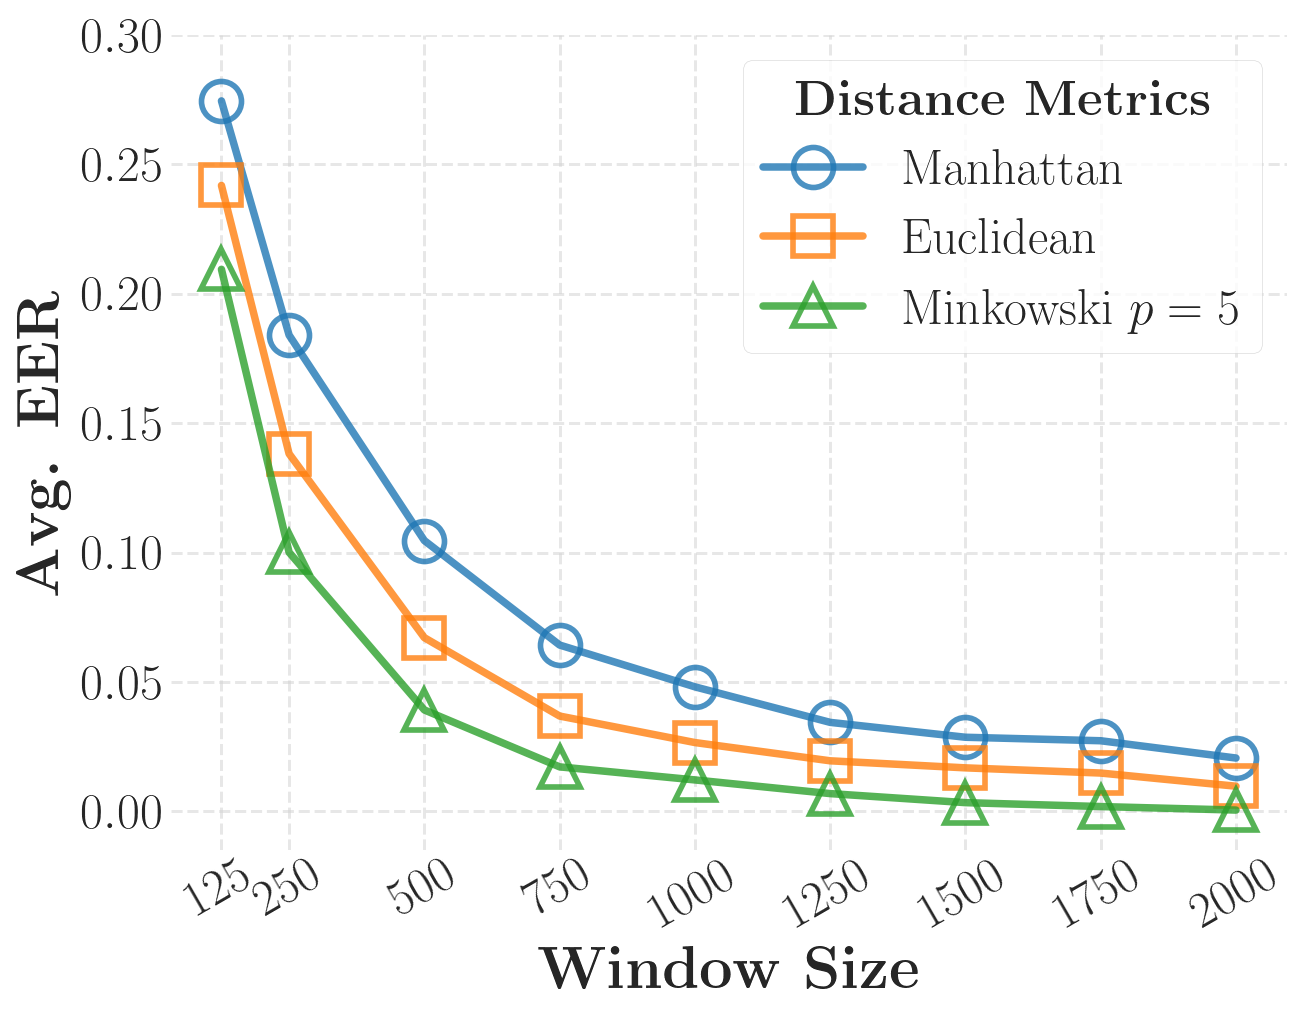

In [329]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(WACA_data_dict_exp2)

plt.figure()


# Create a line plot with multiple series
plt.plot(WACA_data_dict_exp2['x'], WACA_data_dict_exp2[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(WACA_data_dict_exp2['x'], WACA_data_dict_exp2[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(WACA_data_dict_exp2['x'], WACA_data_dict_exp2[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(-0.015, 0.3)

# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Average EER according to different sample sizes using different Minkowski distance metrics while participants are performing Typing Task-2')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer_exp2.svg", format="svg")

# Show the plot
plt.show()


## 1.2) exp1

In [27]:
fma_winsize=2
minkowski_p_lst=[1, 2, 5]


raw_data_dict_exp1={'x': WINDOW_SIZE_LST}
for minkowski_p in minkowski_p_lst:

    raw_data_dict_exp1[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST:
        
        cv_fold_result=[]
        for _, test_cv_fold in THREE_FOLD_CV:
            dis_matrix_dict=make_dist_matrix_dict(dfList_exp=raw_dfList_exp1, 
                                                  user_idx_set=test_cv_fold, 
                                                  feature_extractor_func=WACA_feature_extractor, 
                                                  window_size=window_size, 
                                                  step=window_size, 
                                                  numSamplePoints= P.num_sample_points_per_exp, 
                                                  fma_winsize=fma_winsize)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict_exp1[minkowski_p].append(cv_fold_result)
            
    


data_dict_exp1={}
data_dict_exp1['x']=raw_data_dict_exp1['x']
for minkowski_p in minkowski_p_lst:
    data_dict_exp1[minkowski_p]=np.array(raw_data_dict_exp1[minkowski_p]).mean(axis=1)
    
WACA_data_dict_exp1=data_dict_exp1

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

In [28]:
data_dict_exp1

{'x': [125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],
 1: array([0.27340701, 0.19226343, 0.11544749, 0.08238295, 0.06641451,
        0.04993822, 0.03890409, 0.02888889, 0.02760059]),
 2: array([0.23901681, 0.14580464, 0.07489381, 0.04519424, 0.03142433,
        0.01880633, 0.0154321 , 0.01174074, 0.01089678]),
 5: array([0.2044528 , 0.10706834, 0.04106347, 0.0183122 , 0.00957093,
        0.00718356, 0.00475472, 0.0007037 , 0.00029721])}

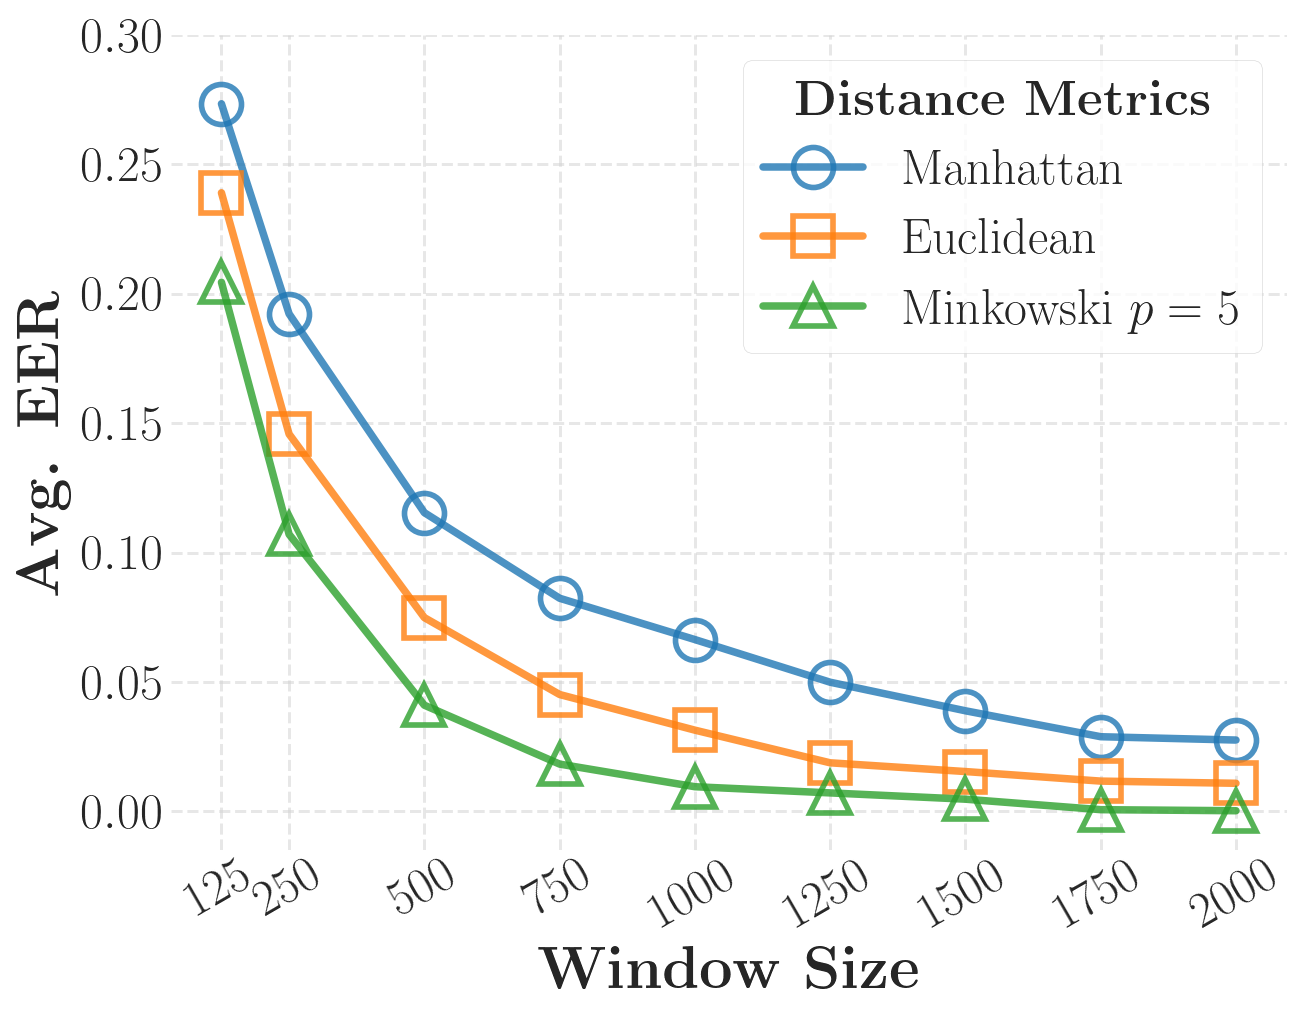

In [330]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(WACA_data_dict_exp1)

# Create a line plot with multiple series
plt.plot(WACA_data_dict_exp1['x'], WACA_data_dict_exp1[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(WACA_data_dict_exp1['x'], WACA_data_dict_exp1[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(WACA_data_dict_exp1['x'], WACA_data_dict_exp1[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(-0.015, 0.3)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Average EER according to different sample sizes using different Minkowski distance metrics while participants are performing Typing Task-1')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer_exp1.svg", format="svg")

# Show the plot
plt.show()


# 2) Classifier free EER distribution exp1 and exp2

## 2.1) exp2 winsize 1000 eer distribution

In [261]:
fma_winsize=2
minkowski_p_lst=[1, 2, 5]
window_size=1000
minkowski_p=5


cv_fold_distribution_result=[]
for _, test_cv_fold in THREE_FOLD_CV:
    dis_matrix_dict=make_dist_matrix_dict(dfList_exp=raw_dfList_exp2,
                                          user_idx_set=test_cv_fold, 
                                          feature_extractor_func=WACA_feature_extractor, 
                                          window_size=window_size, 
                                          step=window_size, 
                                          numSamplePoints= P.num_sample_points_per_exp, 
                                          fma_winsize=fma_winsize)

    eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                       owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                       minkowski_p=minkowski_p)

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

    cv_fold_distribution_result.append(df)
        
            
df=pd.concat(cv_fold_distribution_result, axis=1)

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10


In [262]:
style["xtick.labelsize"]

20

In [282]:
def plot_eer_distribution(df, style, y_lim_max):
    # Create the box plot
    fig, ax = plt.subplots()

    df.boxplot(ax=ax, 
               boxprops={'color': '#2c3e50', 'linewidth': 2},
               medianprops={'color': '#2c3e50', 'linewidth': 2, 'linestyle': '--'},  
               whiskerprops={'color': '#2c3e50', 'linewidth': 2},
               capprops={'color': '#2c3e50', 'linewidth': 2},
               flierprops={'marker': 'o', 'markeredgecolor': '#2c3e50', "markeredgewidth": 2, 'markersize': 6, 'linestyle': 'none'})

    # print(ax.get_xticklabels())
    # Retrieve the x-tick labels, increment by one and set them back
    labels = [str(int(item.get_text()) + 1) for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    # Calculate the average EER (assuming EER is in the data)
    average_eer = df.mean(axis=0).mean()
    print(average_eer)

    # Add a horizontal line for the average EER
    plt.axhline(y=average_eer, color='r', linestyle='-.', marker='', alpha=.8, label='Average EER')

    # Add labels and title
    plt.xlabel(r'\textbf{Participants}')
    plt.ylabel(r'\textbf{EER}')

    legend = plt.legend(frameon=True, title="", loc='upper right')
    for text in legend.get_texts():
        text.set_text(r'\textbf{%s}' % text.get_text())


    ax.grid(False)

    # y_lim_min, y_lim_max = -0.03, 0.28
    y_lim_max_factor=(y_lim_max/0.28)

    y_lim_min = -0.03*y_lim_max_factor

    plt.ylim(y_lim_min, y_lim_max)

    
    staggered_label_y=-0.01*y_lim_max_factor
    relative_y_position = (staggered_label_y - y_lim_min) / (y_lim_max - y_lim_min)

    # Stagger the x-tick labels and grid lines
    for i, label in enumerate(ax.get_xticklabels()):
        xpos = label.get_position()[0]

        if i % 2 == 1:  # for every second label
            label.set_y(relative_y_position)  # shift the label down
            ax.axvline(xpos, color=style["grid.color"], linestyle=style["grid.linestyle"], 
                       linewidth=style["grid.linewidth"], alpha=style["grid.alpha"], ymin=relative_y_position, ymax=1, zorder=0)
        else:
            ax.axvline(xpos, color=style["grid.color"], linestyle=style["grid.linestyle"], 
                       linewidth=style["grid.linewidth"], alpha=style["grid.alpha"], ymin=0, ymax=1, zorder=0)

    # Draw custom horizontal gridlines behind the box plot
    for ypos in ax.get_yticks():
        ax.axhline(y=ypos, color=style["grid.color"], linestyle=style["grid.linestyle"],
                   linewidth=style["grid.linewidth"], alpha=style["grid.alpha"],
                   xmin=0, xmax=1, zorder=0)

0.012196064982920468


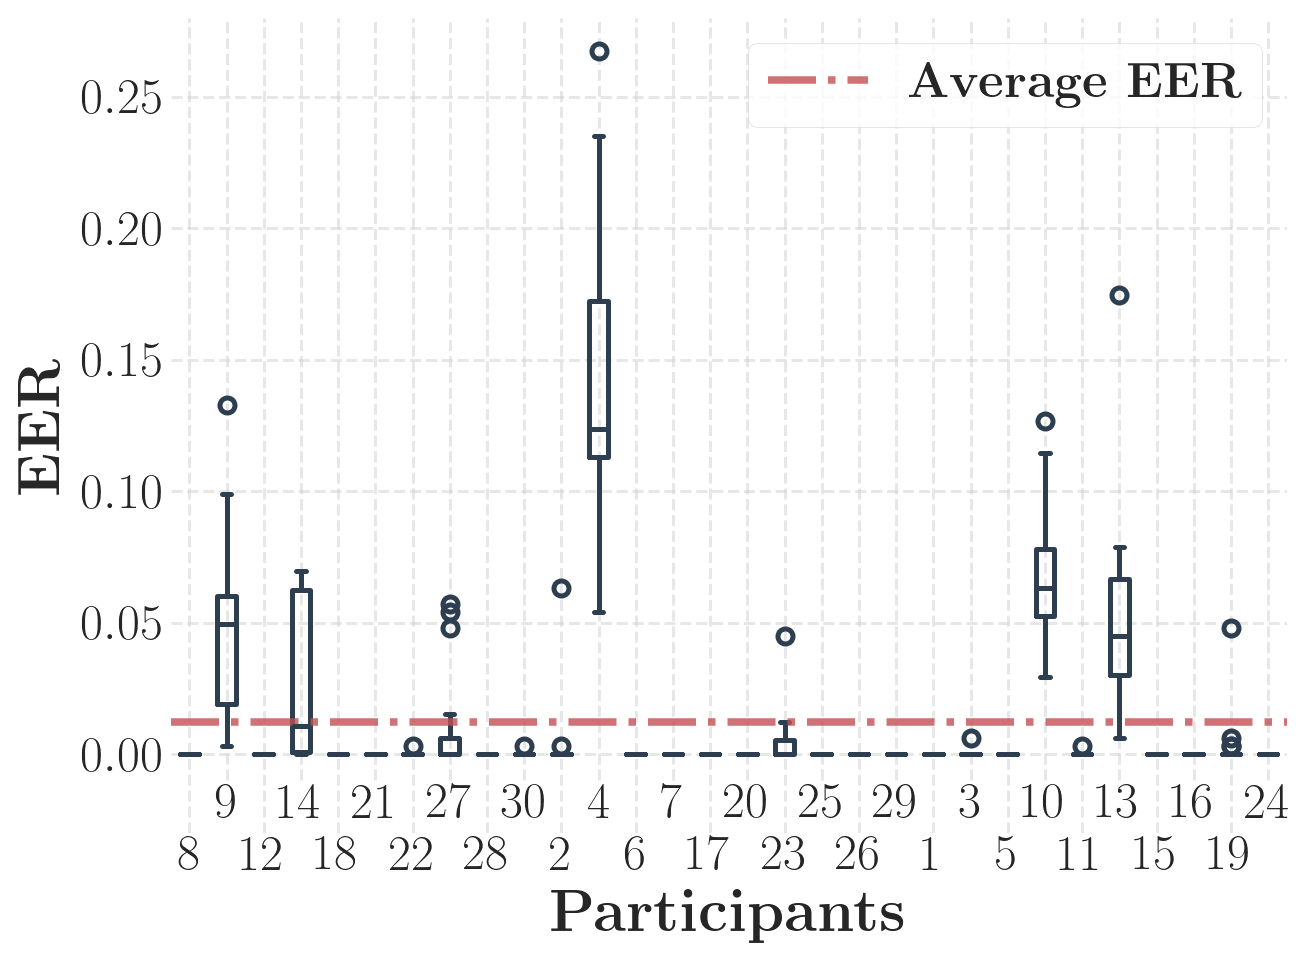

In [264]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've loaded your DataFrame as df
y_lim_max=0.28

plot_eer_distribution(df, style, y_lim_max)
    
plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer-distribution_exp2.svg", format="svg")

# Show the plot
plt.show()


In [265]:
# # Create the box plot
# ax=df.boxplot()


# # Calculate the average EER (assuming EER is in the data)
# average_eer = df.mean(axis=0).mean()

# print(average_eer)
# # Create the box plot

# # df.boxplot()

# # Add a horizontal line for the average EER
# plt.axhline(y=average_eer, color='r', linestyle='-.', marker='', alpha=.8, label='Average EER')


# # Add labels and title
# plt.xlabel(r'\textbf{Participants')
# plt.ylabel(r'\textbf{EER}')
# # plt.title(f"EER distribution for each participant with a window size=1000 using Minkowski distance metric with P=5 during Typing Task-2. Average EER is {average_eer}")

# legend=plt.legend( frameon=True, title="")
# for text in legend.get_texts():
#     text.set_text(r'\textbf{%s}' % text.get_text())
    
# plt.ylim(-0.01, 0.28)

# # for i, label in enumerate(ax.xaxis.get_ticklabels()):
# #     if i % 2 == 0:
# #         label.set_verticalalignment('bottom')
# #     else:
# #         label.set_verticalalignment('top')

# # Stagger the x-tick labels and grid lines
# for i, label in enumerate(ax.get_xticklabels()):
#     xpos = label.get_position()[0]
    
#     if i % 2 == 1:  # for every second label
#         label.set_y(-0.2)  # shift the label down
        
#         # Draw a staggered gridline that extends a bit below the x-axis
#         ax.axvline(xpos, color='gray', linestyle='--', ymin=-0.05, ymax=1, zorder=0)
#     else:
#         ax.axvline(xpos, color='gray', linestyle='--', ymin=0, ymax=1, zorder=0)


# plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer-distribution_exp2.svg", format="svg")

# # Show the plot
# plt.show()

## 2.2) exp1 winsize 1000 eer distribution

In [266]:
fma_winsize=2
minkowski_p_lst=[1, 2, 5]
window_size=1000
minkowski_p=5


cv_fold_distribution_result=[]
for _, test_cv_fold in THREE_FOLD_CV:
    dis_matrix_dict=make_dist_matrix_dict(dfList_exp=raw_dfList_exp1, 
                                          user_idx_set=test_cv_fold, 
                                          feature_extractor_func=WACA_feature_extractor, 
                                          window_size=window_size, 
                                          step=window_size, 
                                          numSamplePoints= P.num_sample_points_per_exp, 
                                          fma_winsize=fma_winsize)

    eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                       owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                       minkowski_p=minkowski_p)

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

    cv_fold_distribution_result.append(df)
        
            
df=pd.concat(cv_fold_distribution_result, axis=1)

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10


0.009570927136286617


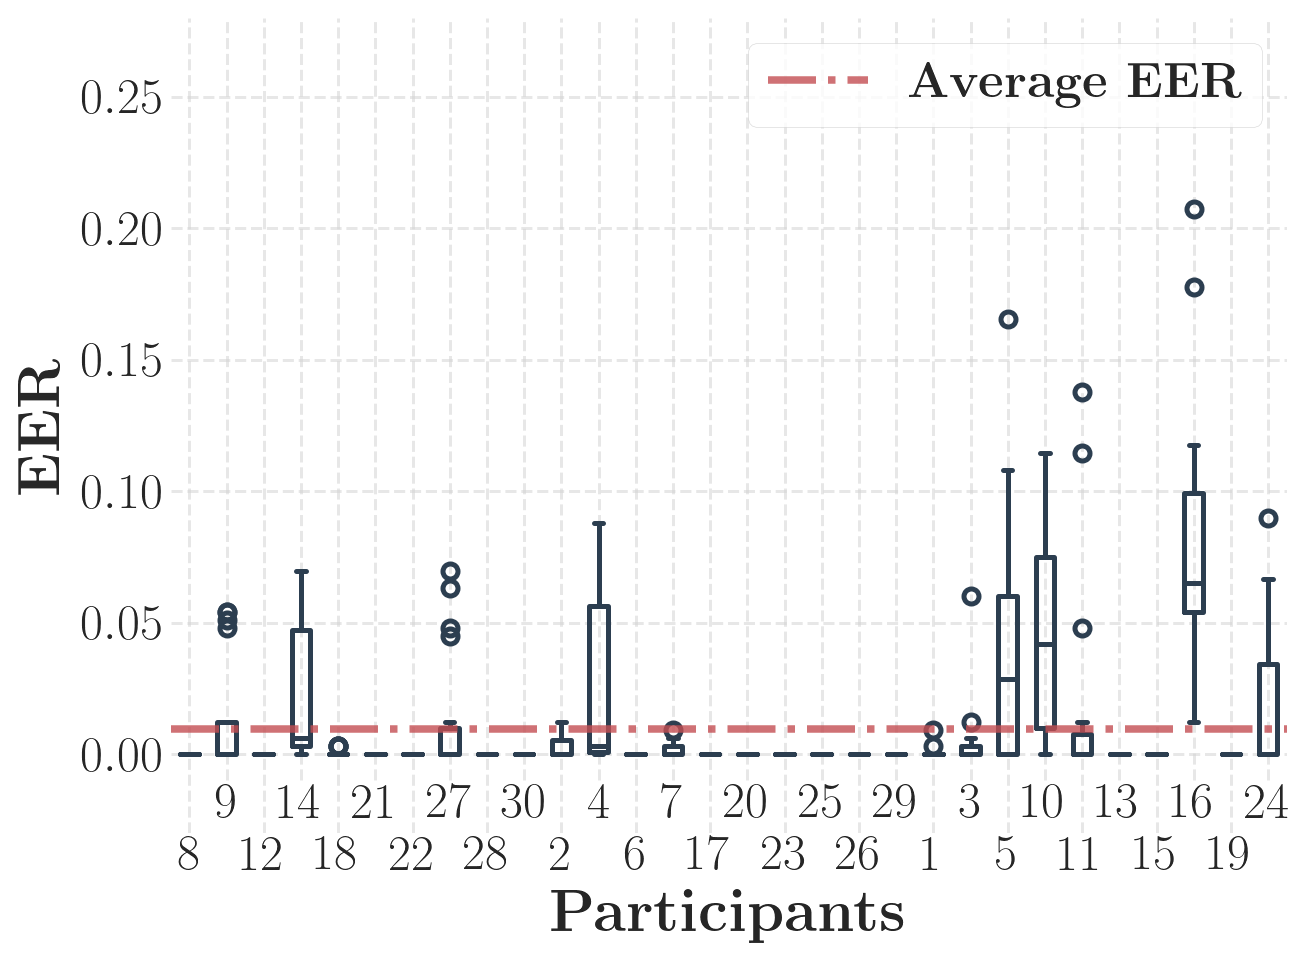

In [269]:
y_lim_max=0.28

plot_eer_distribution(df, style, y_lim_max)

plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer-distribution_exp1.svg", format="svg")

# Show the plot
plt.show()

# 3) Classifier free EER exp2 vs exp1

## 3.1) exp2 vs exp1

In [34]:
fma_winsize=2
minkowski_p_lst=[1, 2, 5]


raw_data_dict_exp2_vs_exp1={'x': WINDOW_SIZE_LST}
for minkowski_p in minkowski_p_lst:

    raw_data_dict_exp2_vs_exp1[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST:
        
        cv_fold_result=[]
        for _, test_cv_fold in THREE_FOLD_CV:
            dis_matrix_dict=make_dist_matrix_dict_exp2_vs_exp1(dfList_exp2=raw_dfList_exp2, 
                                                               dfList_exp1=raw_dfList_exp1, 
                                                               user_idx_set=test_cv_fold, 
                                                               feature_extractor_func=WACA_feature_extractor, 
                                                               window_size=window_size, 
                                                               step=window_size, 
                                                               numSamplePoints= P.num_sample_points_per_exp, 
                                                               fma_winsize=fma_winsize)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict_exp2_vs_exp1[minkowski_p].append(cv_fold_result)
            
    


data_dict_exp2_vs_exp1={"label": "WACA"}
data_dict_exp2_vs_exp1['x']=raw_data_dict_exp2_vs_exp1['x']
for minkowski_p in minkowski_p_lst:
    data_dict_exp2_vs_exp1[minkowski_p]=np.array(raw_data_dict_exp2_vs_exp1[minkowski_p]).mean(axis=1)
    
WACA_data_dict_exp2_vs_exp1=data_dict_exp2_vs_exp1

len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_di

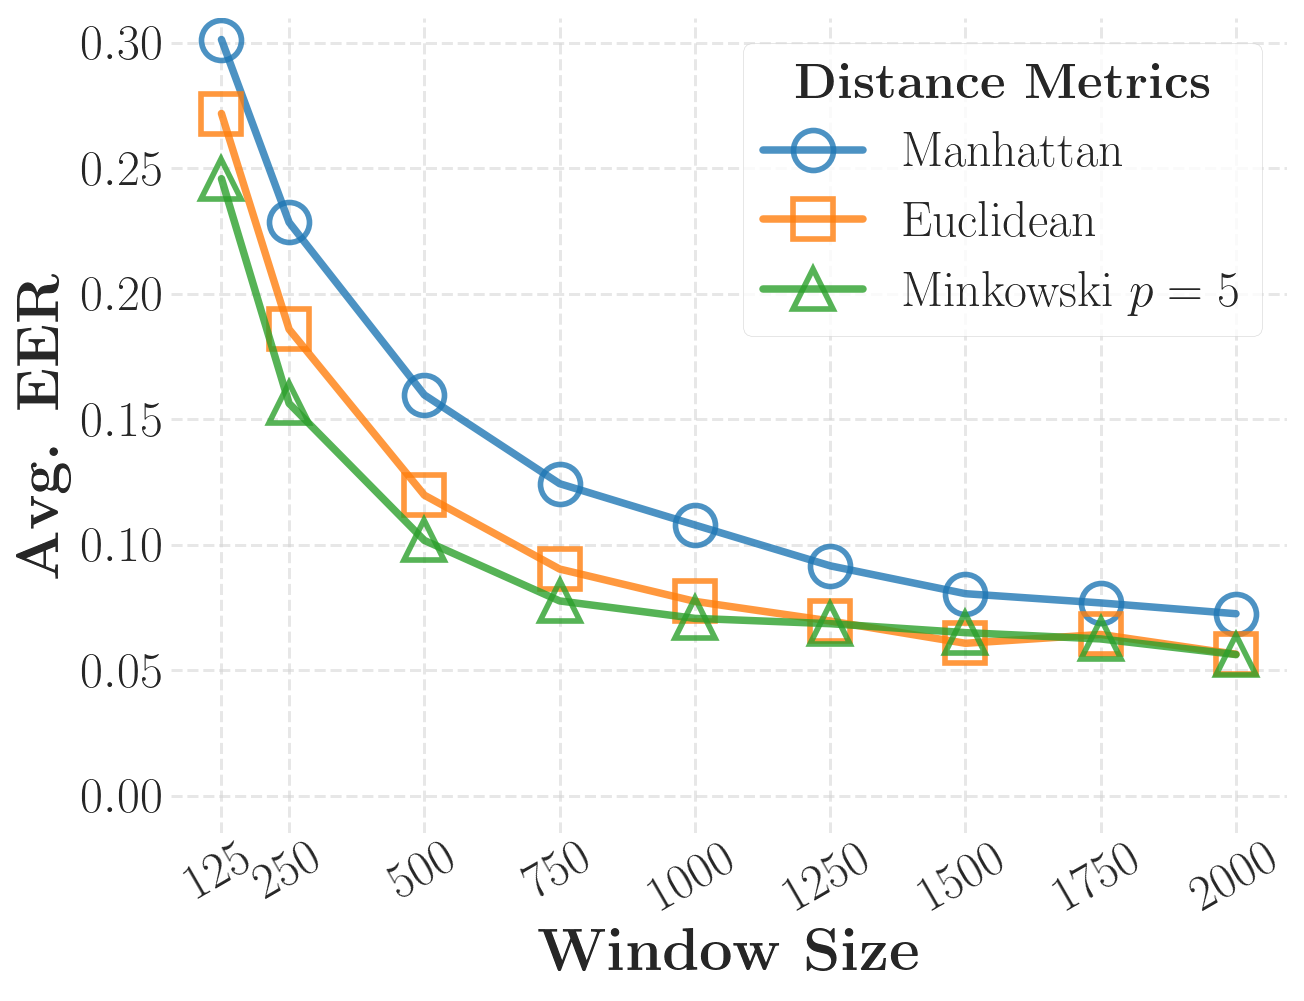

In [368]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(WACA_data_dict_exp2_vs_exp1)

# Create a line plot with multiple series
plt.plot(WACA_data_dict_exp2_vs_exp1['x'], WACA_data_dict_exp2_vs_exp1[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(WACA_data_dict_exp2_vs_exp1['x'], WACA_data_dict_exp2_vs_exp1[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(WACA_data_dict_exp2_vs_exp1['x'], WACA_data_dict_exp2_vs_exp1[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(-0.015, 0.31)



# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Average EER according to different sample sizes using different Minkowski distance metrics while participants are \nperforming Typing Task-1 and are verfied using windows from Typing Task-2')

plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer_exp2-vs-exp1.svg", format="svg")

# Show the plot
plt.show()


## 2.2) exp1 vs exp2, skippping this, since if i do this and want to do the NN equivalent, it would double time of tuning

## 3.2) exp2 vs exp1 eer distribution

In [286]:
fma_winsize=2
minkowski_p_lst=[1, 2, 5]

window_size=1000
minkowski_p=5


cv_fold_distribution_result=[]
for _, test_cv_fold in THREE_FOLD_CV:
    dis_matrix_dict=make_dist_matrix_dict_exp2_vs_exp1(dfList_exp2=raw_dfList_exp2, 
                                                       dfList_exp1=raw_dfList_exp1, 
                                                       user_idx_set=test_cv_fold, 
                                                       feature_extractor_func=WACA_feature_extractor, 
                                                       window_size=window_size, 
                                                       step=window_size, 
                                                       numSamplePoints= P.num_sample_points_per_exp, 
                                                       fma_winsize=fma_winsize)

    eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                       owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                       minkowski_p=minkowski_p)

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

    cv_fold_distribution_result.append(df)
    
df=pd.concat(cv_fold_distribution_result, axis=1)

len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10


0.07067699507786654


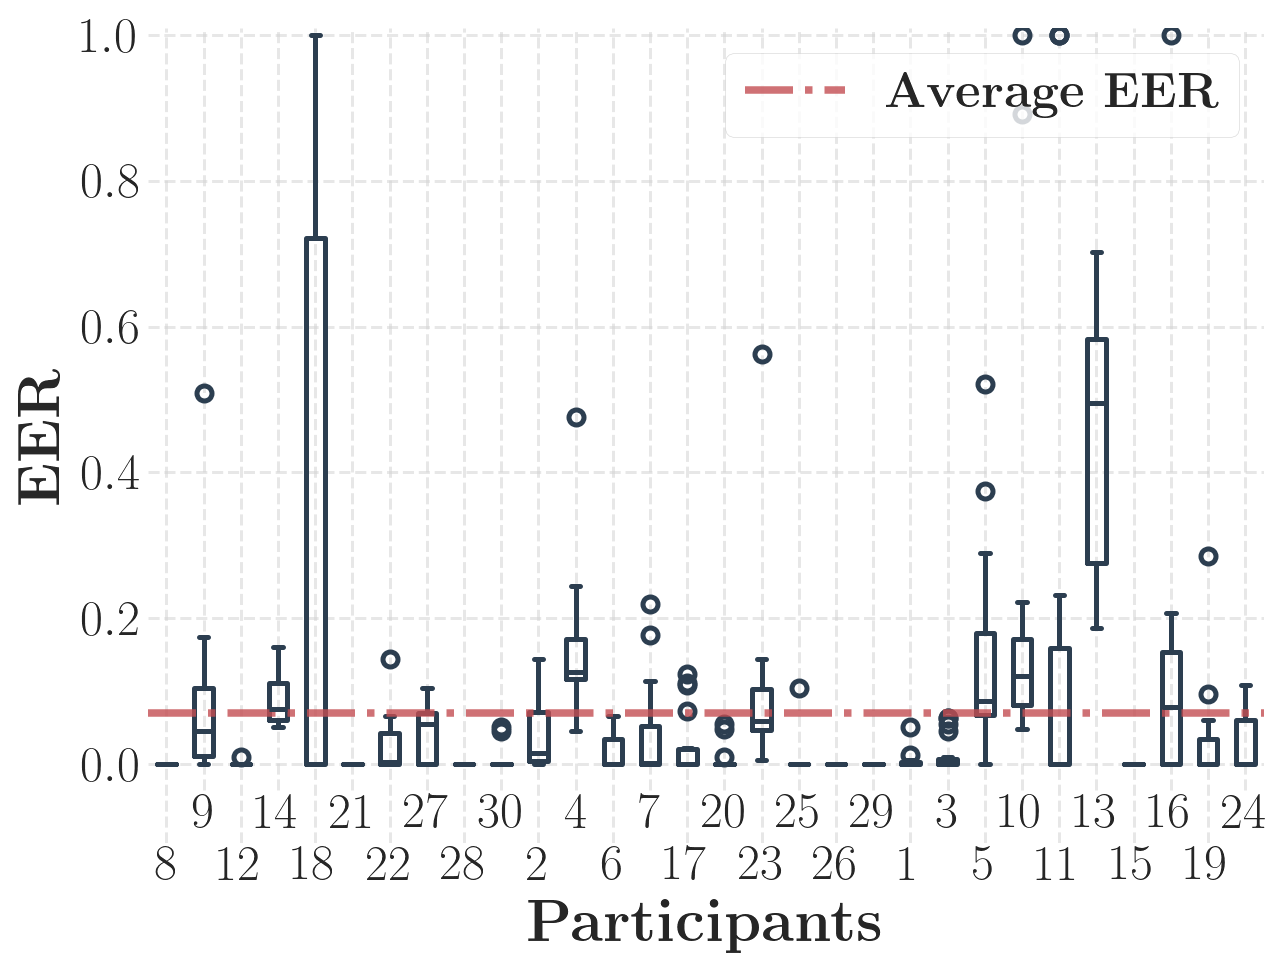

In [287]:
y_lim_max=1.01

plot_eer_distribution(df, style, y_lim_max)

plt.savefig("./thesis_tables_and_figures/classifier-free_WACA_eer-distribution_exp2-vs-exp1.svg", format="svg")

# Show the plot
plt.show()

## 2.4) exp1 vs exp2 eer distribution, skippping this, since if i do this and want to do the NN equivalent, it would double time of tuning

In [137]:
# minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}


# # Create a line plot with multiple series
# plt.plot(data_dict_exp2['x'], data_dict_exp2[5], label=f"exp2, {minkowski_p_label[5]}")
# plt.plot(data_dict_exp1['x'], data_dict_exp1[5], label=f"exp1, {minkowski_p_label[5]}")


# plt.xticks(data_dict_exp2['x'])

# # Add labels, legend, and title
# plt.xlabel(r'\textbf{Window Size}')
# plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Classifier free WACA EER exp2 vs exp1')
# plt.title('Average EER according to different window sizes using the top Minkowski distance metric while participants are performing Typing Task-1 vs Typing Task-2')
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# # P.variant_suffix="optimal_lr-Max_2000x2_tanh"#"optimal_lr"
# # P.variant_suffix="optimal_lr-Max_2000x2_tanh_125_margin=.5"
# # P.variant_suffix="optimal_lr-Max_2000x2_tanh_1000_margin=1.0"
# P.variant_suffix="optimal_lr-Max_2000x2_linear_1000_margin=1.0"
# EXP_PATH_NAME="SCNN-OCSVM"
# WINDOW_SIZE_LST = [1000]#[125, 250, 500, 750, 1000]#, 1250, 1500]#[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

# exp_deep_archi_extractors_dict=get_exp_deep_feature_extractors_dict(exp_num=EXP_NUM_0, model_architectures=["SCNN_3_1_conv_1_dense_arg_dict_default"], variant_suffix=P.variant_suffix)


In [34]:
# del exp_deep_archi_extractors_dict
# gc.collect()

In [36]:
P.num_sample_points_per_exp

18000

# CNN section

## 0. preperation step

In [24]:
minkowski_p_lst=[1, 2, 5]

P.filter_order=10
P.sampling_freq=100
P.filtfilt=1
P.cut_off_freq=33

ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
EMAed_dfList_exp2 = get_EMAed_dfList(ffted_dfList_exp2, span=20)

ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=P.filter_order, sampling_freq=P.sampling_freq, filtfilt=P.filtfilt)
EMAed_dfList_exp1 = get_EMAed_dfList(ffted_dfList_exp1, span=20)


# 1. Classifier free EER distribution exp1 and exp2

## 1.1 Best mean performance

### 1.1.1 Exp2

In [39]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_1_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp2, 
                                                     user_idx_set=test_cv_fold, 
                                                     feature_extractor_func=deep_feature_extractor_func, 
                                                     window_size=window_size, 
                                                     step=window_size, 
                                                     numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={"label": "SCNN_3_1_conv_1_dense"}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)

best_SCNN_data_dict_exp2=data_dict

len(users_exp_df_dict): 10


2023-08-09 07:40:01.199279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

In [36]:
best_SCNN_data_dict_exp2['x']

[125, 250, 500, 750, 1000]

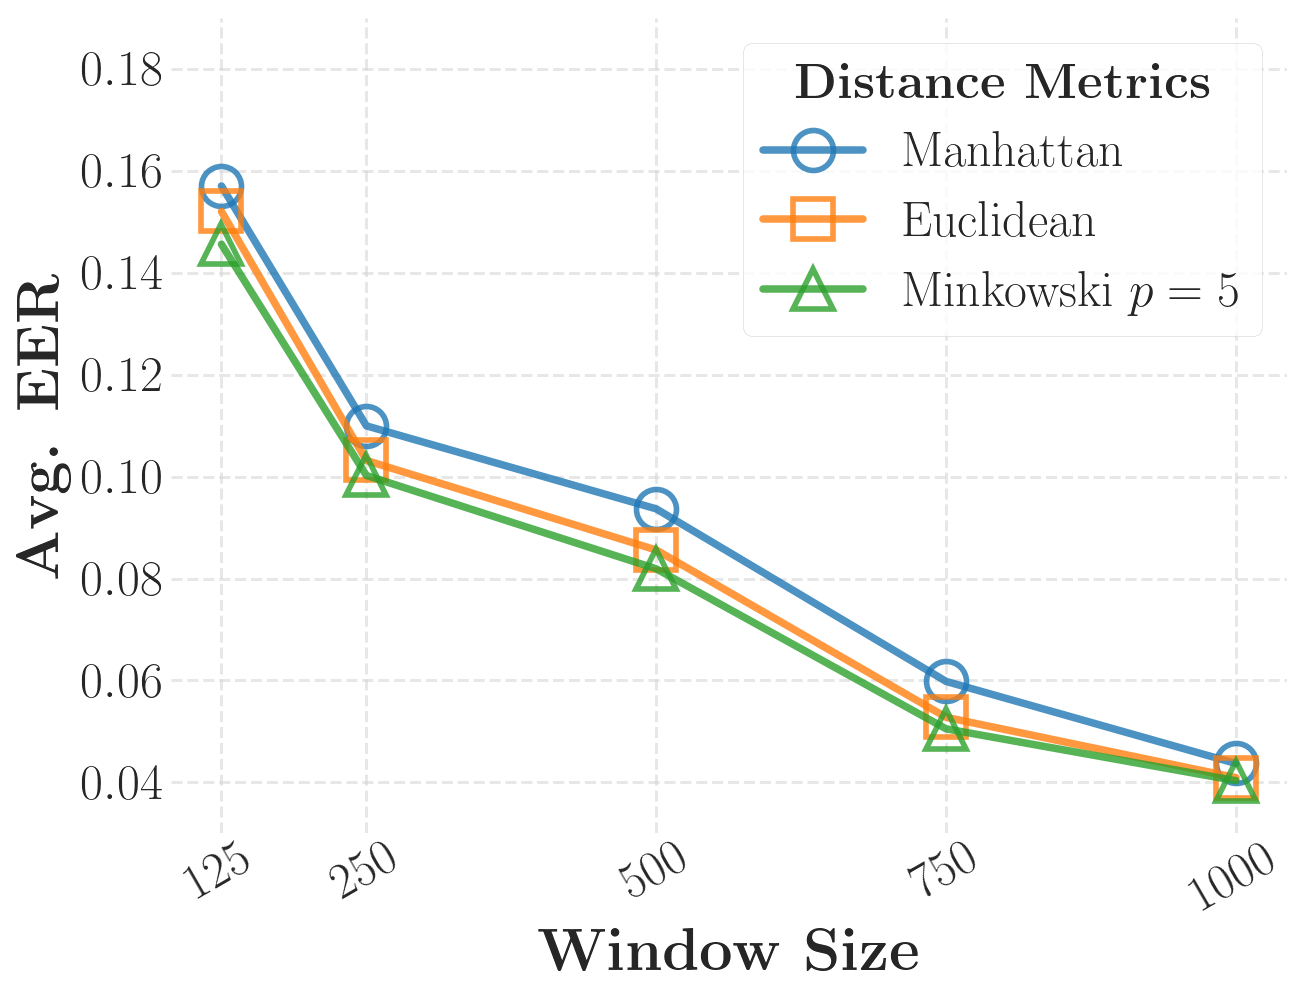

In [366]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(best_SCNN_data_dict_exp2)

# Create a line plot with multiple series
plt.plot(best_SCNN_data_dict_exp2['x'], best_SCNN_data_dict_exp2[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(best_SCNN_data_dict_exp2['x'], best_SCNN_data_dict_exp2[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(best_SCNN_data_dict_exp2['x'], best_SCNN_data_dict_exp2[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(0.03, 0.19)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances Exp2')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_best-SCNN_eer_exp2.svg", format="svg")

# Show the plot
plt.show()

### 1.1.2 Exp1

In [41]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_1_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp1,
                                                     user_idx_set=test_cv_fold, 
                                                     feature_extractor_func=deep_feature_extractor_func, 
                                                     window_size=window_size, 
                                                     step=window_size, 
                                                     numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={"label": "SCNN_3_1_conv_1_dense"}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)
    
best_SCNN_data_dict_exp1=data_dict

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

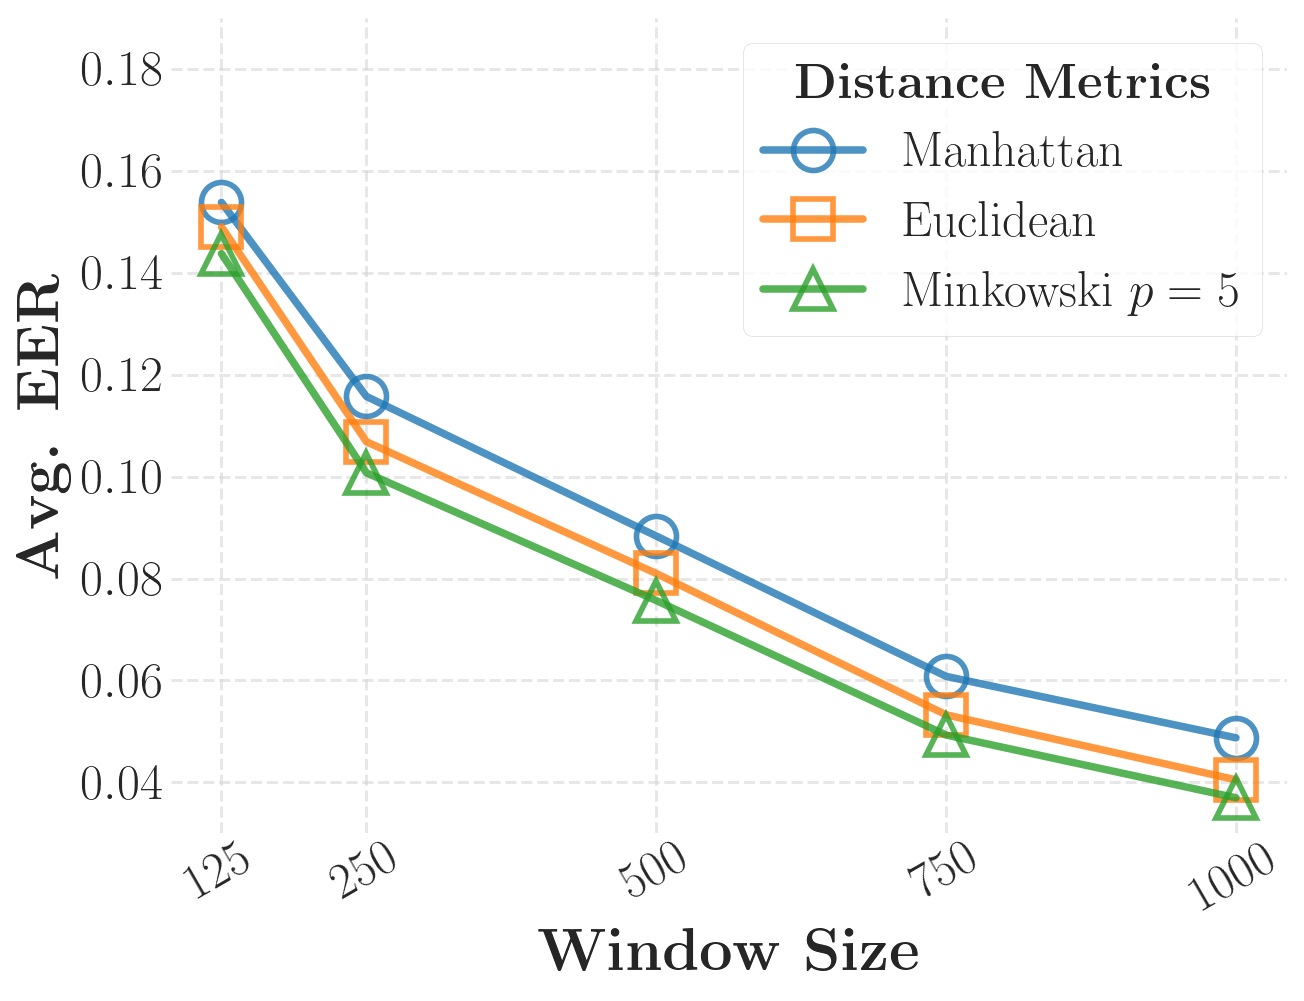

In [365]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(best_SCNN_data_dict_exp1)

# Create a line plot with multiple series
plt.plot(best_SCNN_data_dict_exp1['x'], best_SCNN_data_dict_exp1[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(best_SCNN_data_dict_exp1['x'], best_SCNN_data_dict_exp1[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(best_SCNN_data_dict_exp1['x'], best_SCNN_data_dict_exp1[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(0.03, 0.19)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances Exp2')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_best-SCNN_eer_exp1.svg", format="svg")

# Show the plot
plt.show()

## 1.2 2nd best mean performance

### 1.2.1 Exp2

In [43]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_123_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp2, 
                                                     user_idx_set=test_cv_fold, 
                                                     feature_extractor_func=deep_feature_extractor_func, 
                                                     window_size=window_size, 
                                                     step=window_size, 
                                                     numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={"label": "SCNN_3_123_conv_1_dense"}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)
    
second_best_SCNN_data_dict_exp2=data_dict

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

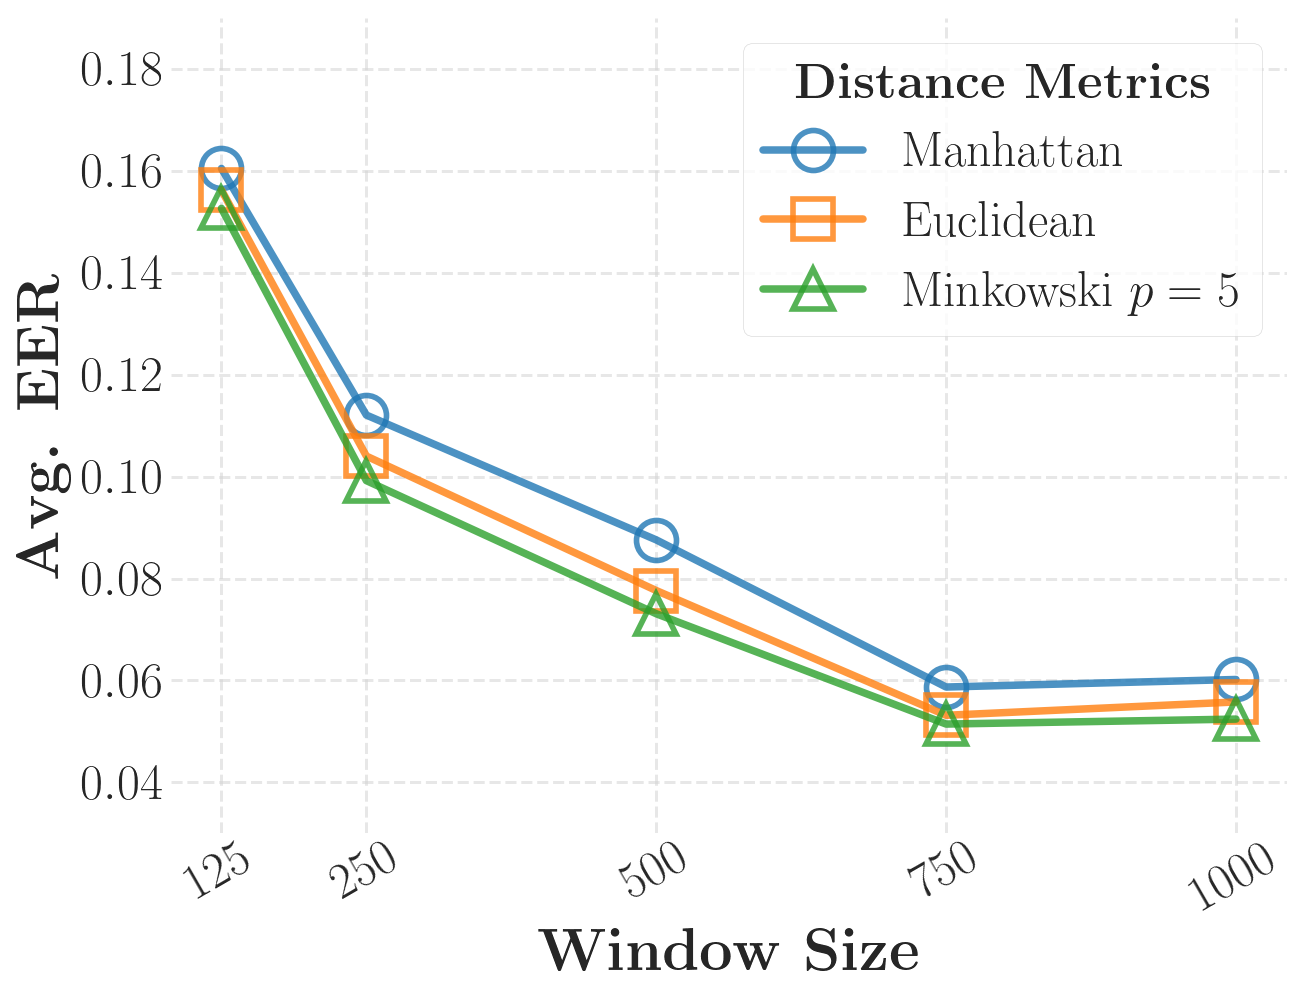

In [364]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(second_best_SCNN_data_dict_exp2)

# Create a line plot with multiple series
plt.plot(second_best_SCNN_data_dict_exp2['x'], second_best_SCNN_data_dict_exp2[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(second_best_SCNN_data_dict_exp2['x'], second_best_SCNN_data_dict_exp2[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(second_best_SCNN_data_dict_exp2['x'], second_best_SCNN_data_dict_exp2[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(0.03, 0.19)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_second-best-SCNN_eer_exp2.svg", format="svg")

# Show the plot
plt.show()

### 1.2.2 Exp1

In [45]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_123_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp1,
                                                     user_idx_set=test_cv_fold, 
                                                     feature_extractor_func=deep_feature_extractor_func, 
                                                     window_size=window_size, 
                                                     step=window_size, 
                                                     numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={"label": "SCNN_3_123_conv_1_dense"}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)
    
second_best_SCNN_data_dict_exp1=data_dict

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

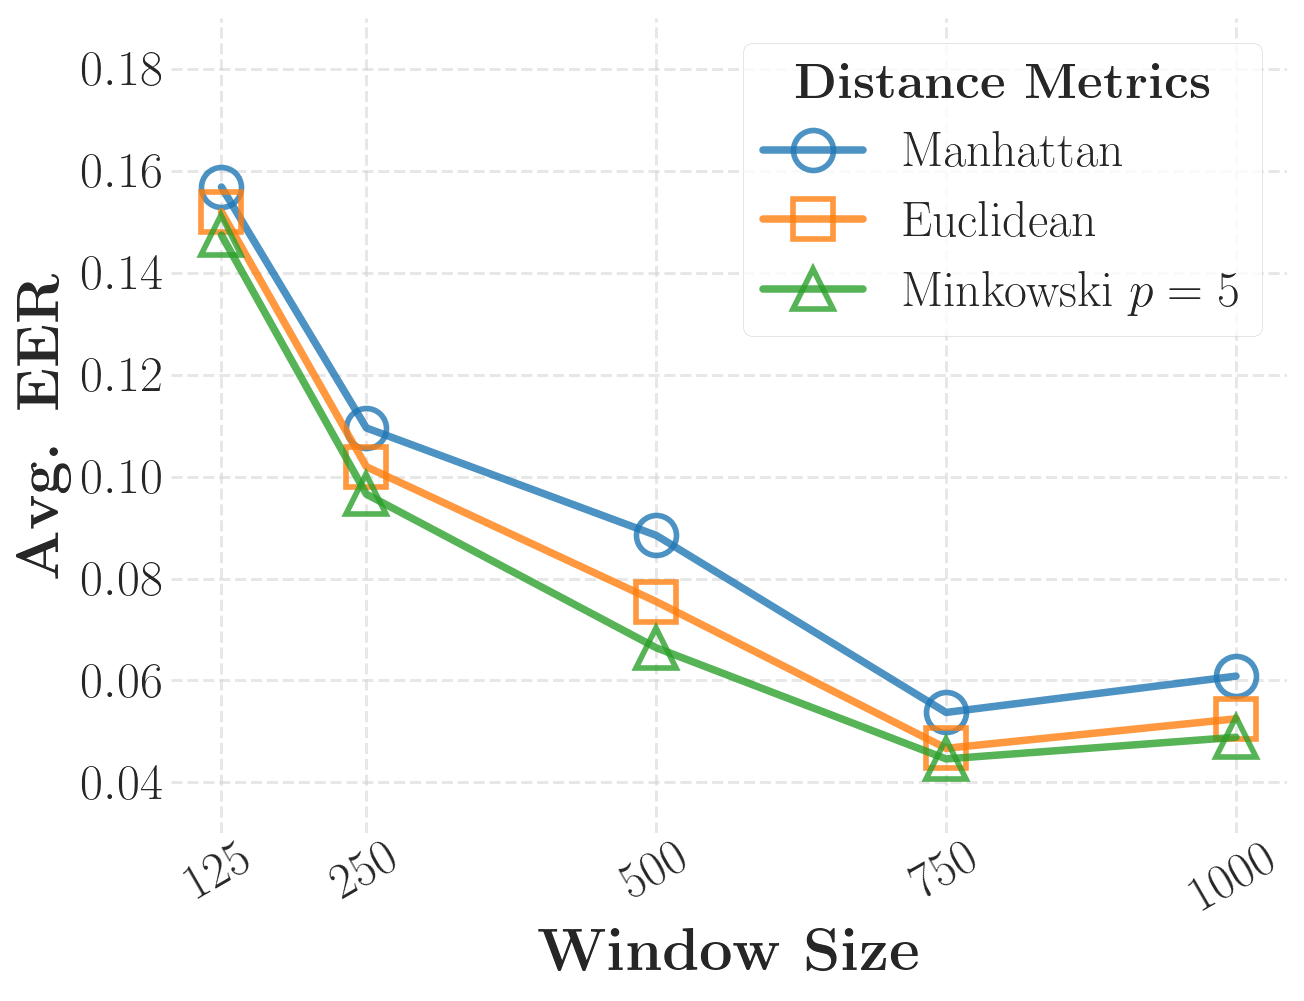

In [363]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(second_best_SCNN_data_dict_exp1)

# Create a line plot with multiple series
plt.plot(second_best_SCNN_data_dict_exp1['x'], second_best_SCNN_data_dict_exp1[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(second_best_SCNN_data_dict_exp1['x'], second_best_SCNN_data_dict_exp1[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(second_best_SCNN_data_dict_exp1['x'], second_best_SCNN_data_dict_exp1[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(0.03, 0.19)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_second-best-SCNN_eer_exp1.svg", format="svg")

# Show the plot
plt.show()

## 1.3 3rd best mean performance

### 1.3.1 Exp2

In [47]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_2_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp2, 
                                                     user_idx_set=test_cv_fold, 
                                                     feature_extractor_func=deep_feature_extractor_func, 
                                                     window_size=window_size, 
                                                     step=window_size, 
                                                     numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={"label": "SCNN_3_2_conv_1_dense"}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)
    
third_best_SCNN_data_dict_exp2=data_dict

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

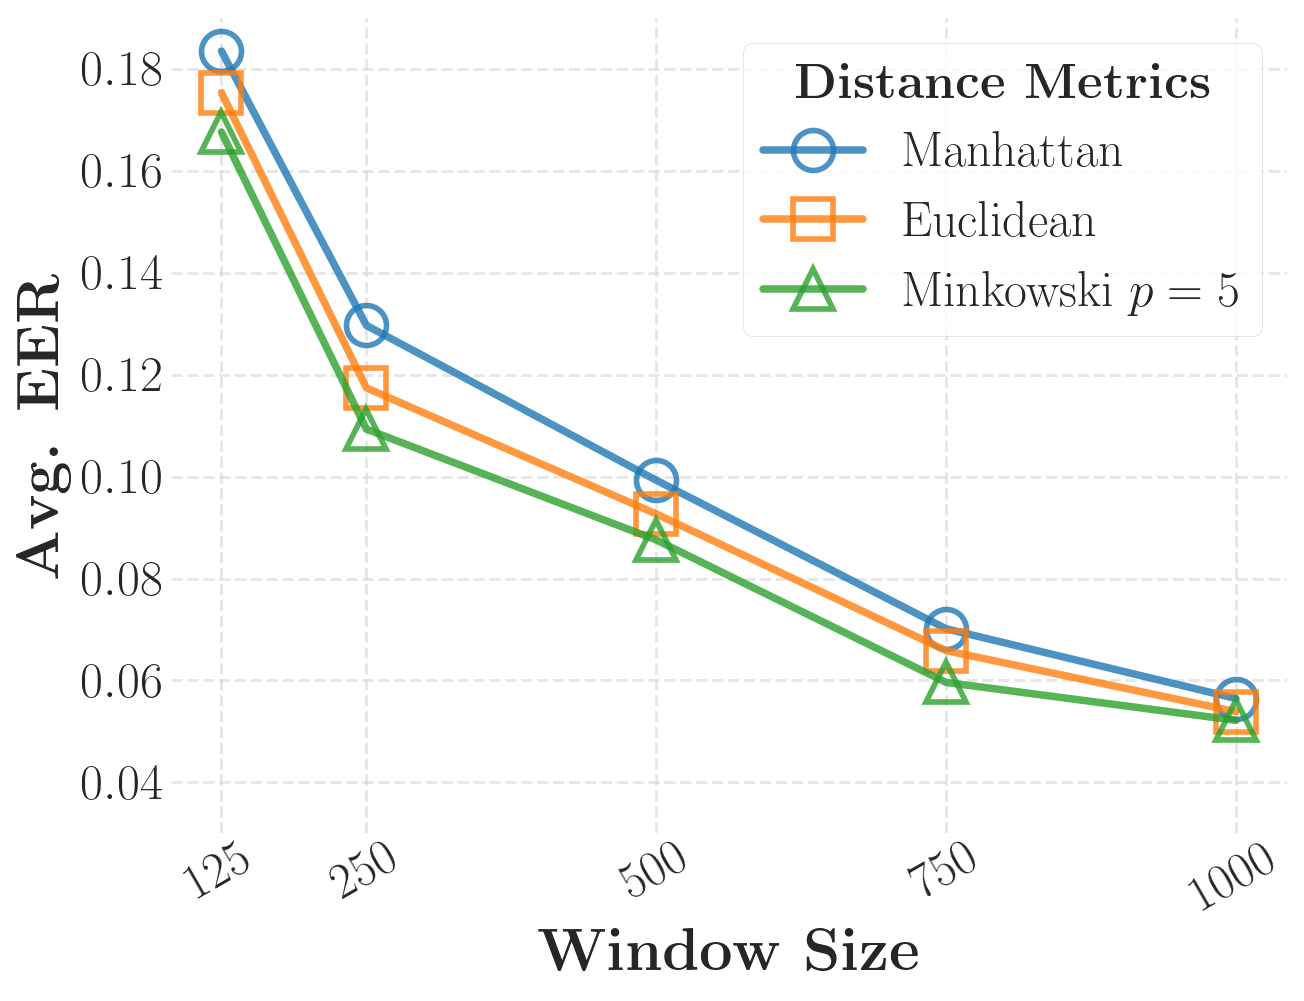

In [361]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(third_best_SCNN_data_dict_exp2)

# Create a line plot with multiple series
plt.plot(third_best_SCNN_data_dict_exp2['x'], third_best_SCNN_data_dict_exp2[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(third_best_SCNN_data_dict_exp2['x'], third_best_SCNN_data_dict_exp2[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(third_best_SCNN_data_dict_exp2['x'], third_best_SCNN_data_dict_exp2[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(0.03, 0.19)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_third-best-SCNN_eer_exp2.svg", format="svg")

# Show the plot
plt.show()

### 1.3.2 Exp1

In [49]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_2_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp1,
                                                     user_idx_set=test_cv_fold, 
                                                     feature_extractor_func=deep_feature_extractor_func, 
                                                     window_size=window_size, 
                                                     step=window_size, 
                                                     numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={"label": "SCNN_3_2_conv_1_dense"}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)
    
third_best_SCNN_data_dict_exp1=data_dict

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
l

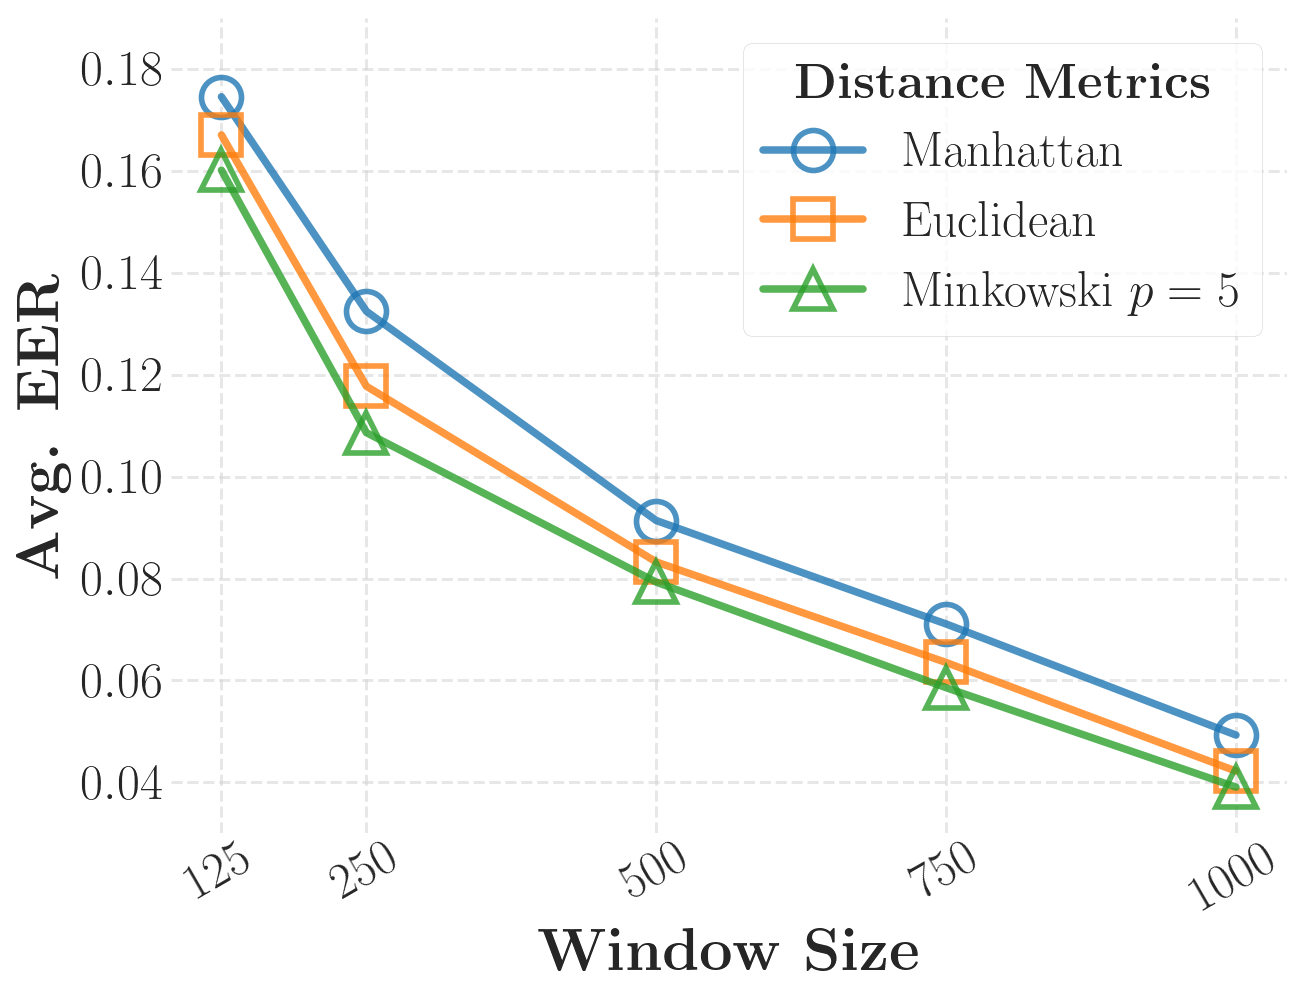

In [362]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(third_best_SCNN_data_dict_exp1)

# Create a line plot with multiple series
plt.plot(third_best_SCNN_data_dict_exp1['x'], third_best_SCNN_data_dict_exp1[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(third_best_SCNN_data_dict_exp1['x'], third_best_SCNN_data_dict_exp1[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(third_best_SCNN_data_dict_exp1['x'], third_best_SCNN_data_dict_exp1[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(0.03, 0.19)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_third-best-SCNN_eer_exp1.svg", format="svg")

# Show the plot
plt.show()

## 1.4 best WACA vs Best metric of all SCNN mean performance

### 1.4.1 Exp2

In [55]:
WACA_data_dict_exp2['x']

[125, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]

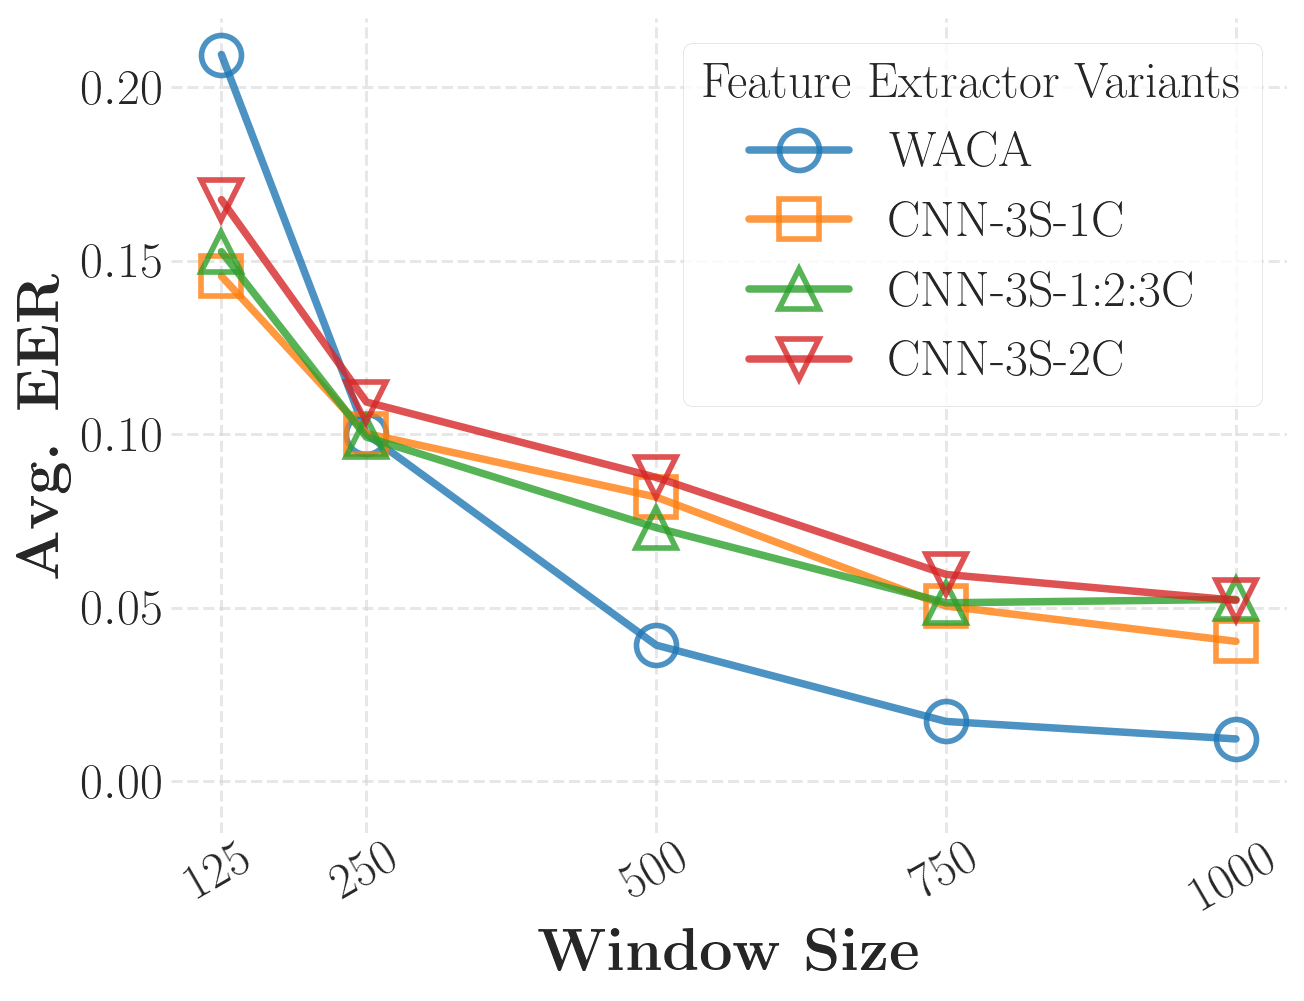

In [351]:
WACA_data_dict_exp2
best_SCNN_data_dict_exp2

minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Create a line plot with multiple series
plt.plot(WINDOW_SIZE_LST_NN, WACA_data_dict_exp2[5][:len(WINDOW_SIZE_LST_NN)], label="WACA", marker=markers[0], alpha=.8)
plt.plot(best_SCNN_data_dict_exp2['x'], best_SCNN_data_dict_exp2[5], label="CNN-3S-1C", marker=markers[1], alpha=.8)
plt.plot(second_best_SCNN_data_dict_exp2['x'], second_best_SCNN_data_dict_exp2[5], label="CNN-3S-1:2:3C", marker=markers[2], alpha=.8)
plt.plot(third_best_SCNN_data_dict_exp2['x'], third_best_SCNN_data_dict_exp2[5], label="CNN-3S-2C", marker=markers[3], alpha=.8)


plt.xticks(best_SCNN_data_dict_exp2['x'])
plt.tick_params(axis='x', rotation=30)
plt.ylim(-0.015, 0.22)



# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances Exp2')
plt.legend( frameon=True, title="Feature Extractor Variants")

plt.savefig("./thesis_tables_and_figures/classifier-free_best-WACA-and-best-all-SCNNs_eer_exp2.svg", format="svg")

# Show the plot
plt.show()

### 1.4.2 Exp1

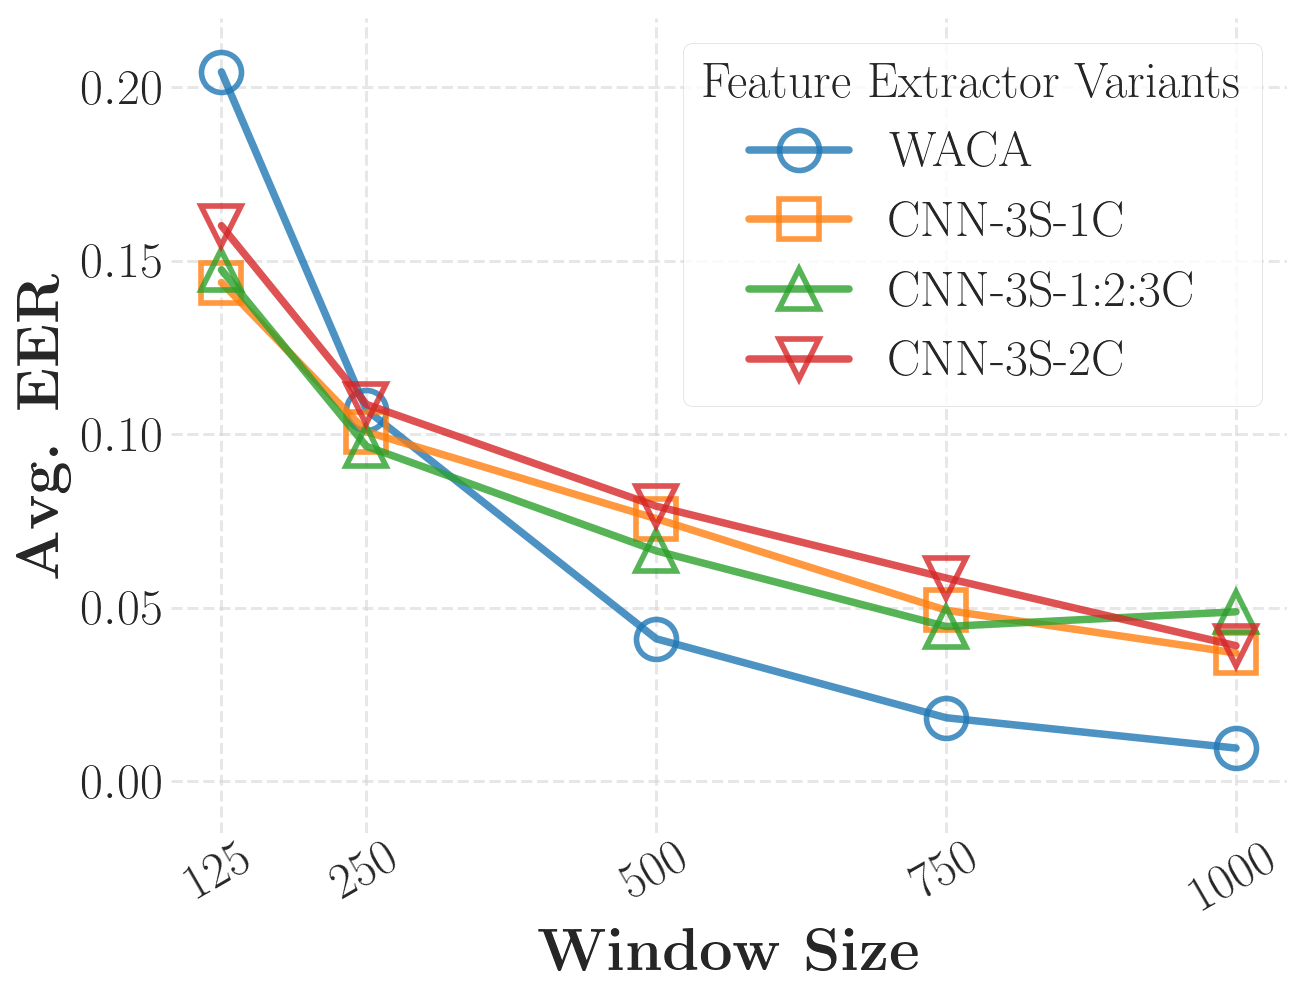

In [349]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# # Convert the dictionary to a DataFrame
# df = pd.DataFrame(data_dict_exp2)

# Create a line plot with multiple series
plt.plot(WINDOW_SIZE_LST_NN, WACA_data_dict_exp1[5][:len(WINDOW_SIZE_LST_NN)], label="WACA", marker=markers[0], alpha=.8)
plt.plot(best_SCNN_data_dict_exp1['x'], best_SCNN_data_dict_exp1[5], label="CNN-3S-1C", marker=markers[1], alpha=.8)
plt.plot(second_best_SCNN_data_dict_exp1['x'], second_best_SCNN_data_dict_exp1[5], label="CNN-3S-1:2:3C", marker=markers[2], alpha=.8)
plt.plot(third_best_SCNN_data_dict_exp1['x'], third_best_SCNN_data_dict_exp1[5], label="CNN-3S-2C", marker=markers[3], alpha=.8)


plt.xticks(best_SCNN_data_dict_exp1['x'])
plt.tick_params(axis='x', rotation=30)
plt.ylim(-0.015, 0.22)



# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances Exp2')
plt.legend( frameon=True, title="Feature Extractor Variants")

plt.savefig("./thesis_tables_and_figures/classifier-free_best-WACA-and-best-all-SCNNs_eer_exp1.svg", format="svg")

# Show the plot
plt.show()

# 2. Distribution of the best CNN

## 2.1 Exp2

In [304]:
window_size=1000
minkowski_p=5


cv_fold_distribution_result=[]
for cv_fold_idx in range(len(THREE_FOLD_CV)):

    _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]

    deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_1_conv_1_dense_arg_dict_default"][window_size]

    dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp2, 
                                             user_idx_set=test_cv_fold, 
                                             feature_extractor_func=deep_feature_extractor_func, 
                                             window_size=window_size, 
                                             step=window_size, 
                                             numSamplePoints= P.num_sample_points_per_exp)

    eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                       owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                       minkowski_p=minkowski_p)

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

    cv_fold_distribution_result.append(df)
    
df=pd.concat(cv_fold_distribution_result, axis=1)

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10


0.04031845934532936


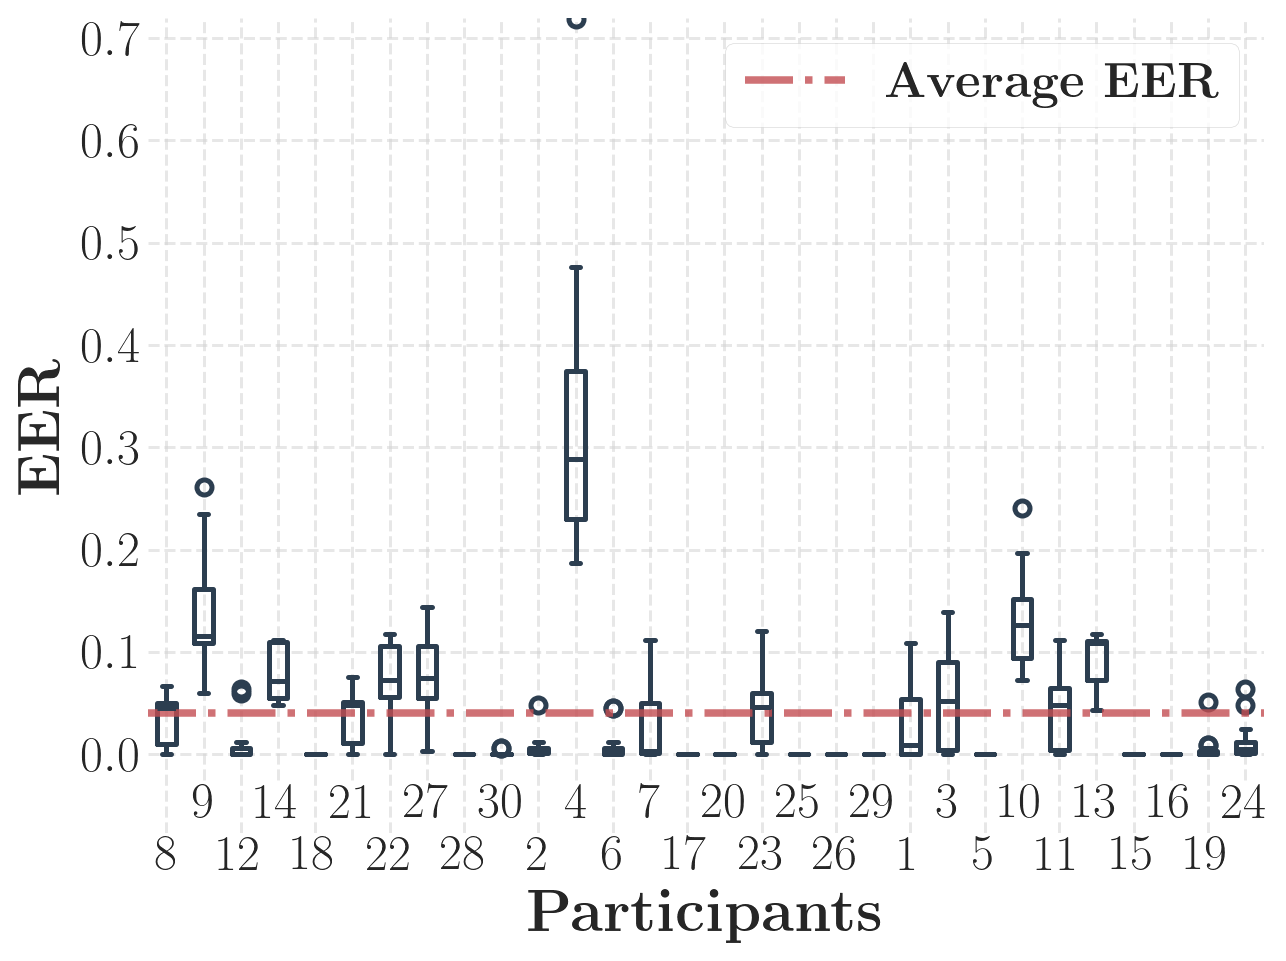

In [305]:
y_lim_max=0.72

plot_eer_distribution(df, style, y_lim_max)

plt.savefig("./thesis_tables_and_figures/classifier-free_best-SCNN_eer-distribution_exp2.svg", format="svg")

# Show the plot
plt.show()

## 2.2 Exp1

In [307]:
window_size=1000
minkowski_p=5


cv_fold_distribution_result=[]
for cv_fold_idx in range(len(THREE_FOLD_CV)):

    _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]

    deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_1_conv_1_dense_arg_dict_default"][window_size]

    dis_matrix_dict=make_dist_matrix_dict_NN(dfList_exp=EMAed_dfList_exp1, 
                                             user_idx_set=test_cv_fold, 
                                             feature_extractor_func=deep_feature_extractor_func, 
                                             window_size=window_size, 
                                             step=window_size, 
                                             numSamplePoints= P.num_sample_points_per_exp)

    eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                       owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                       minkowski_p=minkowski_p)

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

    cv_fold_distribution_result.append(df)
    
df=pd.concat(cv_fold_distribution_result, axis=1)

len(users_exp_df_dict): 10
len(users_exp_df_dict): 10
len(users_exp_df_dict): 10


0.036971812044433686


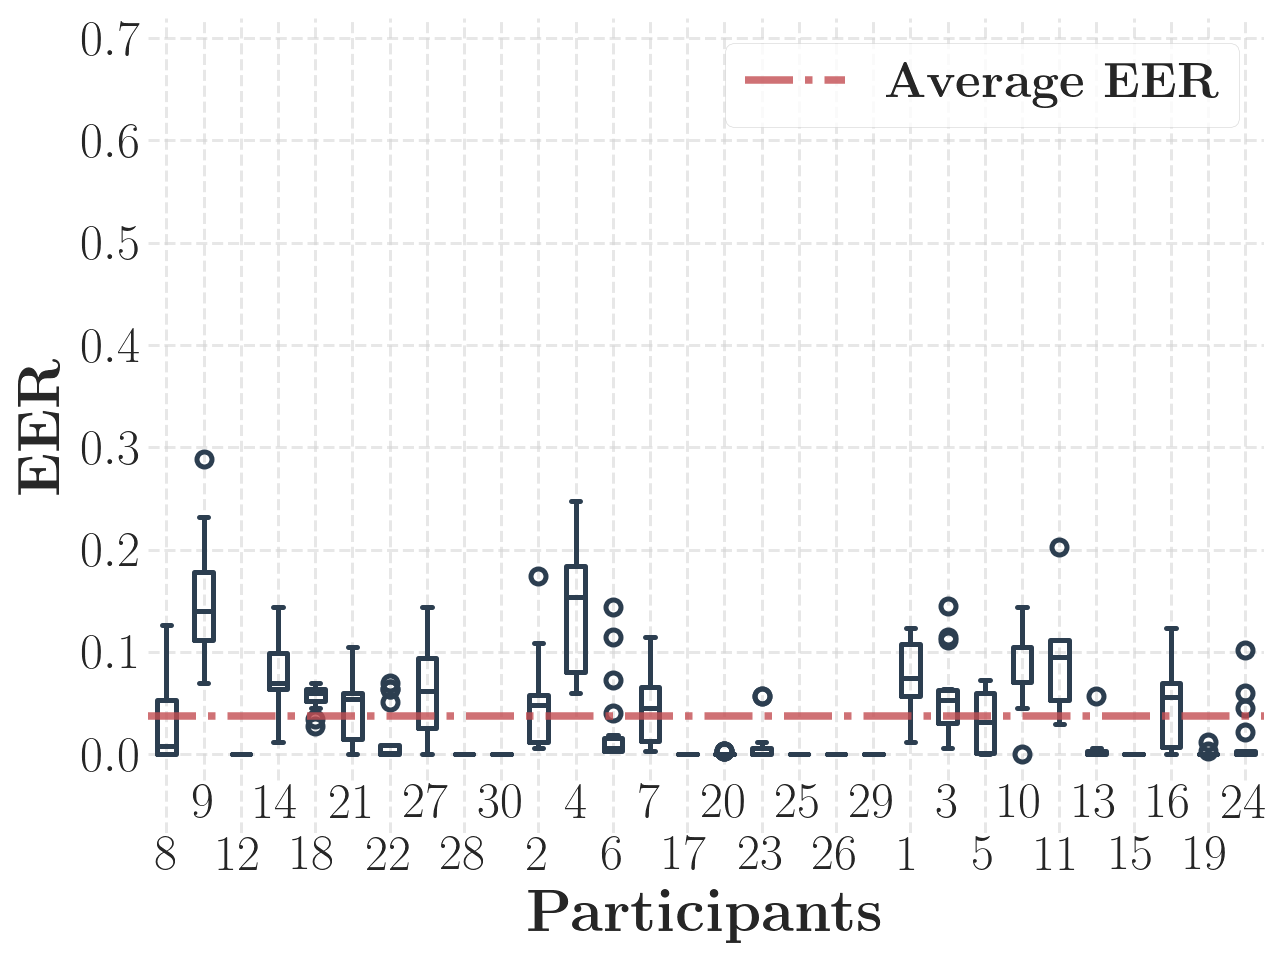

In [308]:
y_lim_max=0.72

plot_eer_distribution(df, style, y_lim_max)

plt.savefig("./thesis_tables_and_figures/classifier-free_best-SCNN_eer-distribution_exp1.svg", format="svg")

# Show the plot
plt.show()

# 3. Classifier free EER exp2 vs exp1 EER vs Window Size and distribution of the best SCNN 

## 3.1 Exp2 vs Exp1 EER

In [ ]:
raw_data_dict={'x': WINDOW_SIZE_LST_NN}
for minkowski_p in minkowski_p_lst:

    raw_data_dict[minkowski_p]=[]
    for window_size in WINDOW_SIZE_LST_NN:
        
        cv_fold_result=[]
        
        for cv_fold_idx in range(len(THREE_FOLD_CV)):
            
            _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]
            
            deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_1_conv_1_dense_arg_dict_default"][window_size]
        
            dis_matrix_dict=make_dist_matrix_dict_NN_exp2_vs_exp1(dfList_exp2=EMAed_dfList_exp2, 
                                                                  dfList_exp1=EMAed_dfList_exp1, 
                                                                  user_idx_set=test_cv_fold, 
                                                                  feature_extractor_func=deep_feature_extractor_func, 
                                                                  window_size=window_size, 
                                                                  step=window_size, 
                                                                  numSamplePoints= P.num_sample_points_per_exp)

            eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                               owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                               minkowski_p=minkowski_p)

            df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))
            
            cv_fold_result.append(df.mean(axis=0).mean())
        
        raw_data_dict[minkowski_p].append(cv_fold_result)

    
# del EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT
# gc.collect()

data_dict={}
data_dict['x']=raw_data_dict['x']
for minkowski_p in minkowski_p_lst:
    data_dict[minkowski_p]=np.array(raw_data_dict[minkowski_p]).mean(axis=1)
    
SCNN_data_dict_exp2_vs_exp1=data_dict

len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10


2023-08-24 23:11:15.123446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_di

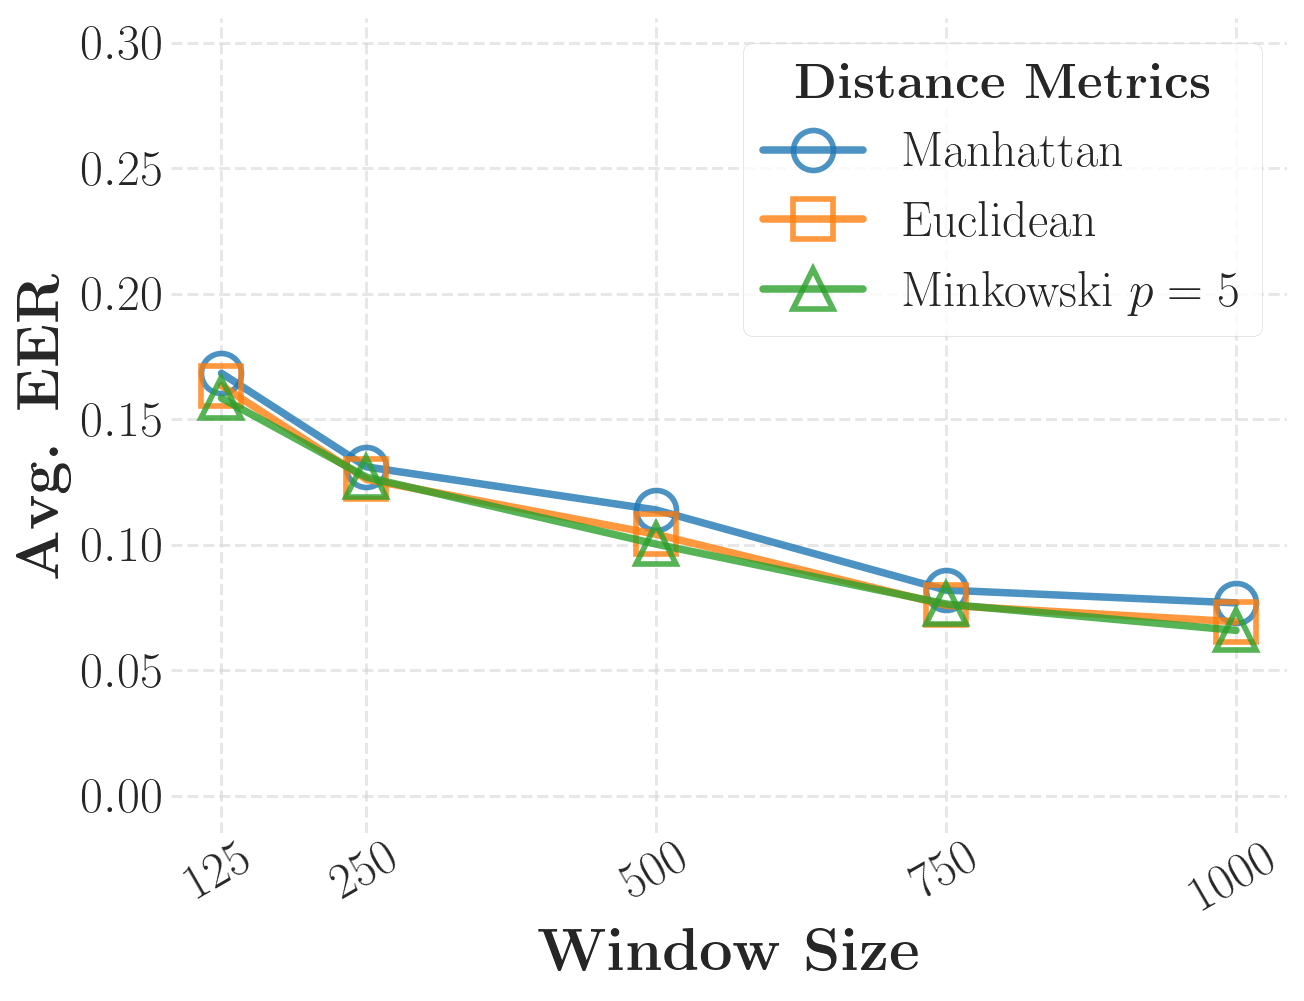

In [27]:
minkowski_p_label={1: "Manhattan", 2: "Euclidean", 5: "Minkowski $p=5$"}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(SCNN_data_dict_exp2_vs_exp1)

# Create a line plot with multiple series
plt.plot(SCNN_data_dict_exp2_vs_exp1['x'], SCNN_data_dict_exp2_vs_exp1[1], label=minkowski_p_label[1], marker=markers[0], alpha=.8)
plt.plot(SCNN_data_dict_exp2_vs_exp1['x'], SCNN_data_dict_exp2_vs_exp1[2], label=minkowski_p_label[2], marker=markers[1], alpha=.8)
plt.plot(SCNN_data_dict_exp2_vs_exp1['x'], SCNN_data_dict_exp2_vs_exp1[5], label=minkowski_p_label[5], marker=markers[2], alpha=.8)


plt.xticks(df['x']) 
plt.tick_params(axis='x', rotation=30)
plt.ylim(-0.015, 0.31)


# Add labels, legend, and title
plt.xlabel(r'\textbf{Window Size}')
plt.ylabel(r'\textbf{Avg. EER}')
# plt.title('Minkowski Distances Exp2')
plt.legend( frameon=True, title=r"\textbf{Distance Metrics}")

plt.savefig("./thesis_tables_and_figures/classifier-free_best-SCNN_eer_exp2-vs-exp1.svg", format="svg")

# Show the plot
plt.show()

## 3.1.2 Exp2 vs Exp1 EER Distribution

In [284]:
window_size=1000
minkowski_p=5


cv_fold_distribution_result=[]
for cv_fold_idx in range(len(THREE_FOLD_CV)):

    _, test_cv_fold = THREE_FOLD_CV[cv_fold_idx]

    deep_feature_extractor_func=EXP_DEEP_ARCHI_EXTRACTORS_DICT_CV_DICT[cv_fold_idx]["SCNN_3_1_conv_1_dense_arg_dict_default"][window_size]

    dis_matrix_dict=make_dist_matrix_dict_NN_exp2_vs_exp1(dfList_exp2=EMAed_dfList_exp2, 
                                                          dfList_exp1=EMAed_dfList_exp1,
                                                          user_idx_set=test_cv_fold, 
                                                          feature_extractor_func=deep_feature_extractor_func, 
                                                          window_size=window_size, 
                                                          step=window_size, 
                                                          numSamplePoints= P.num_sample_points_per_exp)

    eer_result_dict=calculate_user_EER(owner_owner_dis_matrix_dict=dis_matrix_dict["owner_owner_dis_matrix_dict"], 
                                       owner_adversary_dis_matrix_dict=dis_matrix_dict["owner_adversary_dis_matrix_dict"], 
                                       minkowski_p=minkowski_p)

    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in eer_result_dict.items()]))

    cv_fold_distribution_result.append(df)
    
df=pd.concat(cv_fold_distribution_result, axis=1)


len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10
len(owner_exp_df_dict): 10
len(unknown_exp_df_dict): 10


0.06589640657360338


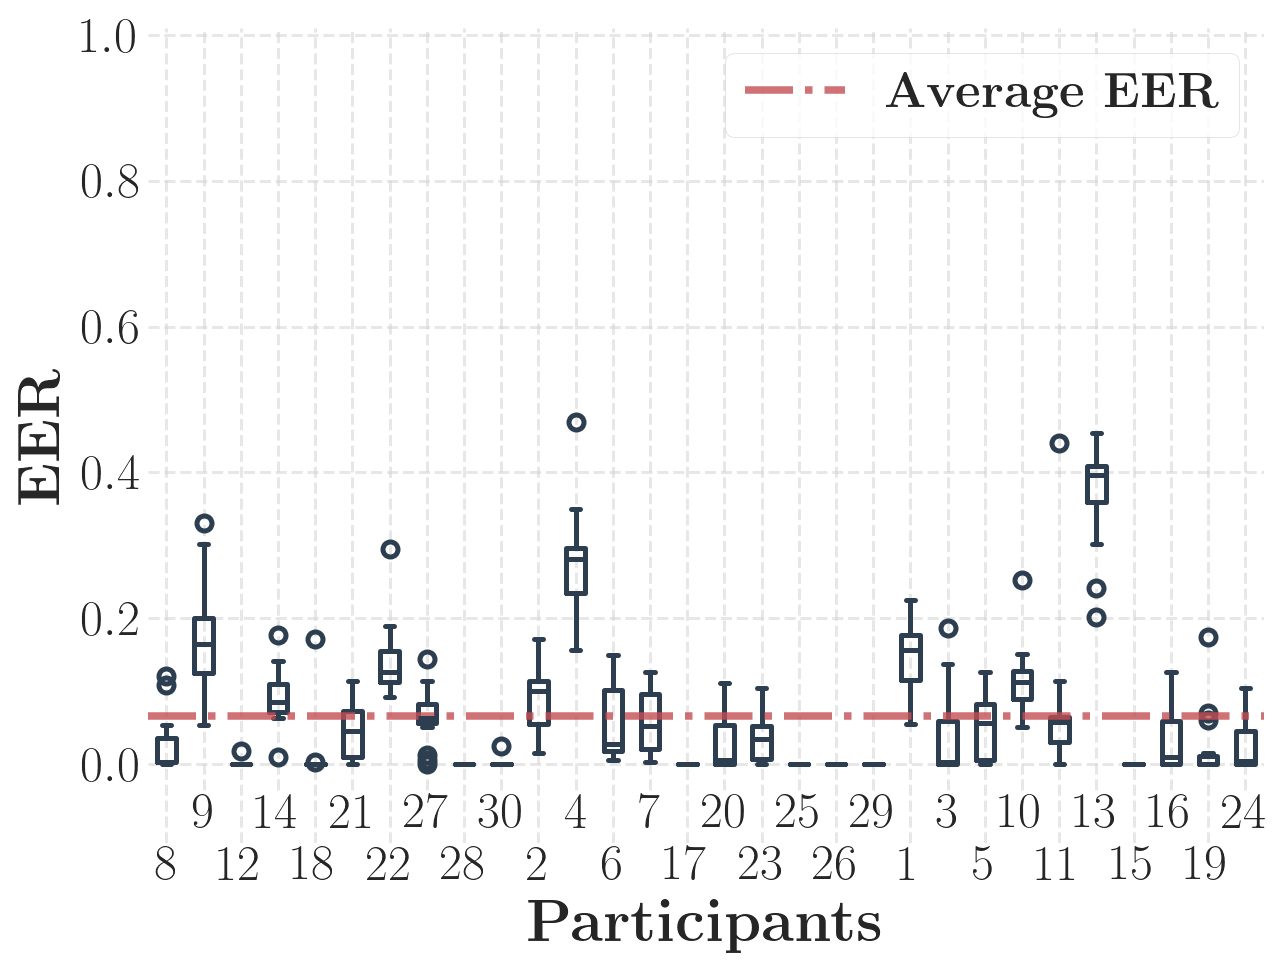

In [285]:
y_lim_max=1.01

plot_eer_distribution(df, style, y_lim_max)

plt.savefig("./thesis_tables_and_figures/classifier-free_best-SCNN_eer-distribution_exp2-vs-exp1.svg", format="svg")

# Show the plot
plt.show()